In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
import random
import pickle


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error
from math import sqrt, log
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeClassifier, LinearRegression, Ridge
import graphviz

from sklearn.tree import tree, export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from matplotlib import pyplot as plt
from IPython.display import Image, display
from sklearn.utils import class_weight
from xgboost import XGBClassifier
import xgboost
import re
#%matplotlib inline
#plt.style.use('ggplot')
SEED = 42
np.random.seed(SEED)

from selenium import webdriver
from bs4 import BeautifulSoup
from time import sleep
from fake_useragent import UserAgent
import requests
import shutil
import os
from webdriver_manager.chrome import ChromeDriverManager

pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 400)


# Functions

## Processing

In [178]:
def remove_missing_salary(df):
    
    '''
    Removes -9999.99 in the salary variable who are people who are either doing further studies or 
    working but did not disclose  
        @df: Main dataframe 
    '''
    
    df = df[df["salary"] != "-9999.99"]
    
    return df

def group_salary_into_subgroup(df):
    
    '''
    combine salary group into subgroups 
        @df: Main dataframe 
    '''
   
    df = df.copy()
    '''
    df["salary"][df["salary"].isin(["10000.0", "15000.0"])] = "5000 to 15000"
    df["salary"][df["salary"].isin(["20000.0"])] = "15000 to 20000"
    df["salary"][df["salary"].isin(["25000.0"])] = "20000 to 25000"
    df["salary"][df["salary"].isin(["30000.0", "35000.0"])] = "25000 to 35000"
    df["salary"][df["salary"].isin(["40000.0", "45000.0"])] = "35000 to 45000"
    df["salary"][df["salary"].isin(["50000.0", "55000.0", "60000.0", "65000.0", "70000.0", "70000.01"])] = "more than 45000"
    '''
    
    df["salary"][df["salary"].isin(["10000.0", "15000.0", "20000.0"])] = "less than 20000"
    df["salary"][df["salary"].isin(["25000.0", "30000.0"])] = "20000 to 30000"
    df["salary"][df["salary"].isin(["35000.0", "40000.0"])] = "30000 to 40000"
    df["salary"][df["salary"].isin(["45000.0", "50000.0"])] = "40000 to 50000"
    df["salary"][df["salary"].isin(["55000.0", "60000.0", "65000.0", "70000.0", "70000.01"])] = "more than 50000"
    
    return df

def adjust_salary_continuous(x):
    
    '''
    Randomly assign a salary value to its lower or upper bound (15,000 will remain 15,000 or go down to 10,000)
    70,000.01 is converted to 75,000
        @x: Salary value from the salary column 
    '''
    
    n_r = np.random.uniform(0, 1)
    
    if x == 70000.01:
        
        return 75000
    
    #if (n_r > 0.5) & (x != 0):
        
     #   return x - 5000
    
    return x



def process_y_variable_employment(df, remove_salary_variable = True):
    
    '''
    Convert all unemployed guys to 1 and all guis with a salary to 0
        @df: Main dataframe 
    '''
    
    df["employment"] = 0
    df["employment"][df["F_XACTIV02"] == 8] = 1
    
    #remove guys with no salary who are not unemployed (example doing further studies)
    df = df[np.logical_not((df["employment"] == 0) & (df["salary"] == -9999.99))]
    
    #remove salary variable which we dont need anymore 
    if remove_salary_variable:
        df = df.drop("salary", axis = 1)
    
    df["employment"] = df["employment"].astype("float")
    
    return df


def process_y_variable_salary_categorical(df, classes):
    
    '''
    Keep salary as a categorical variables, process it, and divide it into subgroups of salary range
        @df: Main dataframe 
        @classes: string indicating whether or not we keep the unemployed class
    '''
    
    #1) Convert to string
    df["salary"] = df["salary"].astype("str")
    
    if classes != "only salary":
        #2) Extract unemployed people (number 8 in the F_XACTIV02 variable) from the F_XACTIV02 variable
        df["salary"][df["F_XACTIV02"] == 8] = "unemployed"
    
    #3) Remove the remaining -9999.99 who either doing further studies or working but did not disclose 
    #salary information
    df = remove_missing_salary(df) 
    
    #4) group salary into bigger categories
    df = group_salary_into_subgroup(df)
    
    return df


def process_y_variable_salary_continuous(df, classes):
    
    '''
    Converts the salary variable to a continuous one
        @df: Main dataframe 
        @classes: Set unemployed people as 0 if classes != "only salary"
    '''
    
    if classes != "only salary":
        df["salary"][df["F_XACTIV02"] == 8] = 0

    df = df[df["salary"] != -9999.99]
    
    df["salary"] = df["salary"].map(adjust_salary_continuous)
 
    return df



def process_y_variable_salary(df, type_y, classes):
    
    '''
    Process y variable salary into continuous or categorical
        @df: Main dataframe 
        @type_y: Type of the y variable (continuous or categorical)
        @classes: Set unemployed people as 0 if classes != "only salary"
    '''
   
    if type_y == "continuous":
        df = process_y_variable_salary_continuous(df, classes)
    elif type_y == "categorical":
        df = process_y_variable_salary_categorical(df, classes)
    
    
    return df


def process_y_variable(df, prediction, type_y, classes):
    
    '''
    Make processing on the y variable (salary) by adding unemployed people and removing the -9999.99 values  
        @df: Main dataframe 
    '''
    
    df = df.copy()
    
    if prediction == "salary":
        df = process_y_variable_salary(df, type_y, classes)
    elif prediction == "employment":
        df = process_y_variable_employment(df, remove_salary_variable = True)
    
    return df


def get_main_course_area(df):
    
    '''
    Extracts the course letter from F_XJACS01 to get the main area of subject course
        @df: Main dataframe 
    '''
    
    df["subject_area"] = df["F_XJACS01"].str[0]
    
    l_letter = ["A", "B", "C", "D", "F", "G", "I", 
            "H", "J", "K", "L", "M", "N", "P", "Q", 
            "R", "T", "V", "W", "X"]

    #removing agriculture
    l_letter_jacs = ["Medicine & dentistry", 
                     "Subjects allied to medicine", 
                     "Biological sciences", 
                     "Veterinary science", 
                     "Physical sciences", 
                     "Mathematical sciences", 
                     "Computer science", 
                     "Engineering & technology",
                     "Engineering & technology",
                     "Architecture, building & planning", 
                     "Social studies", 
                     "Law", 
                     "Business & administrative studies", 
                     "Mass communications & documentation", 
                     "Languages", 
                     "Languages", 
                     "Languages", 
                     "Historical & philosophical studies", 
                     "Creative arts & design", 
                     "Education"]
    
    series_jacs_letter = pd.Series(l_letter_jacs, index = l_letter)
    
    df["jacs"] = df["subject_area"].map(series_jacs_letter)
    
    df = df.drop("subject_area", axis = 1)
    
    return df

def get_main_qualification_letter(df):
    
    '''
    Extracts the qualification letter from F_XOBTND01 to get the main qualification (undergrad, postgrad etc...)
        @df: Main dataframe 
    '''
    
    df["qualification_letter"] = df["F_XOBTND01"].str[0]
    #df = df[df["qualification_letter"] == "M"]
    
    return df


def compare_diff_years(d):
    
    '''
    Different cases of the difference between F_YEARSTU and F_YEARPRG
        @d: A series of the difference between F_YEARSTU and F_YEARPRG
    '''
    
    if d > 0: 
        return "late"
    elif d <= 0:
        return "normal"
    else:
        return "unknown"


def compare_year_prog_and_year_stud(df):
    
    '''
    Compares the year the student is currently in and the year of the program: Returns "late" if the student has
    retaken a year because of a change in course if he is retaking a year, "normal" if the year the student is in
    is the same as the year of the program and unknown is there is a missing value in of the 2 columns
        @df: Main dataframe 
    '''
    
    df = df.copy()
    
    l_year = ["F_YEARSTU", "F_YEARPRG"]
    
    for var_year in l_year:
        
        df[var_year][df[var_year] == "6 and over"] = "6"
        
        df[var_year + "_numeric"] = pd.to_numeric(df[var_year], errors = "coerce")
        
    df["year_difference"] = df[l_year[0] + "_numeric"] - df[l_year[1] + "_numeric"]
    
    df["year_late"] = df["year_difference"].map(lambda d: compare_diff_years(d))
        
    return df

def imput_NA_in_degree_class(df):
    
    '''
    Replace missing values in F_XCLASS01 by "unknown"
        @df: Main dataframe 
    '''
    
    df["F_XCLASS01"] = df["F_XCLASS01"].fillna("unknown")
    
    return df

def remove_under_represented_class(df, l_var, thresh = 1.4):
    
    '''
    Delete data points who belongs to a class in the variables of l_var that make up for thresh % of the total 
    number of data points
        @df: Main dataframe 
        @l_var: List of variables for which we remove the points belonging to the least represented classes:
            F_MSTUFEE: Major source of tuition fees (Full)
            F_XAGRPJ01:Age of leaver (17 & under/ 18-20/ 21-24/ 25-29/ 30 & over/ Unknown)
            F_XLOCUC01: Location of employment (Country)
        @thresh: Threshold of minimum percentage of points accross the least represented classes before removing 
        then
    '''
    
    for var in l_var:
    
        for i in range(df[var].value_counts().size):

            prop = df[var].value_counts()[i:].sum()/df.shape[0] * 100

            if prop < thresh:

                l_class_to_keep = df[var].value_counts()[:i].index
                break

        df = df[df[var].isin(l_class_to_keep)]    
            
        
    return df

def match_uni_ranking(x, df_uni_all):
    
    '''
    Match the university from complete university guide with the university name from the HESA dictionary to 
    get universities ranking. There are 3 cases scenarios:
        1) The fuzzy matching recognizes the university correctly and get a fuzzy score greater than 86
        2) The university in the HESA dict is not in the complete university guide, in this case return not ranked
        3) The university is in the complete university guide but the fuzy did not work. In this case replace 
        manually
        @x: A university from the HESA dictionary
        @df_uni_all: The dataframe scraped from the complete university guide with uni name, ranking and type (art
        or regular)
    '''
    
    dict_no_match = {"Imperial College of Science, Technology and Medicine":5, 
                     "Goldsmiths College":72, 
                     "Royal Holloway and Bedford New College":23, 
                     "Glyndŵr University":130}
    
    if x in dict_no_match.keys():
        
        return (x, dict_no_match[x], 1, 100)
    
    uni = process.extractOne(x, df_uni_all["university"])
    
    if uni[1] > 86:
        
        ranking = df_uni_all["ranking"][df_uni_all["university"] == uni[0]]
        uni_type = df_uni_all["type"][df_uni_all["university"] == uni[0]]

        return (uni[0], ranking.iloc[0], uni_type.iloc[0], uni[1])
    else:
        return ("not ranked", "unknown", 1, 0)


def create_uni_ranking_var(df_main, df_dict, df_uni_all):
    
    '''
    Build the ranking variable for each university
        @df_main: Main dataframe 
        @df_dict: Dictionary label from the HESA dictionary
        @df_uni_all:  The dataframe scraped from the complete university guide with uni name, ranking and type (art
        or regular)
    '''
    
    #select only labels related to university names
    df_dict = df_dict[df_dict["Field Name"] == "F_XINSTID01"]
    
    #clean the university name column by removing the figures before
    df_dict["uni_name"] = df_dict["Label"].str[5:]
    
    #convert to float to match the data column from the dict with the F_XINSTID01 column from the main df
    df_dict["Data"] = pd.to_numeric(df_dict["Data"])
    
    df_dict["match"] = df_dict["uni_name"].apply(lambda x: match_uni_ranking(x, df_uni_all))
    
    #convert the returned tuple into different columns
    df_dict["uni_complete_guide"] = df_dict["match"].str[0]
    df_dict["ranking"] = df_dict["match"].str[1]
    df_dict["uni_type"] = df_dict["match"].str[2]
    df_dict["fuzzi_score"] = df_dict["match"].str[3]
    
    #join the main dataframe and the completed HESA dictionary with university ranking information
    df_main = pd.merge(df_main, df_dict, left_on = "F_XINSTID01", right_on = "Data")
    
    return df_main

def create_uni_ranking_range(df, bins = 13):
    
    '''
    Convert university ranking into categories of bins
        @df: Main dataframe 
        @bins: Number of sub categories to create in the university ranking
    '''
    
    df["ranking_range"] = "unknown"
    ranking = df["ranking"][df["ranking"] != "unknown"]
    df["ranking_range"][df["ranking"] != "unknown"] = pd.cut(ranking, bins = bins, labels = False)
    
    return df

def remove_useless_var(df):
    
    '''
    Remove built in variables, those we replaced or we cant use
        @df: Main dataframe 
    '''
    
    var = ["AcYear",
           #"F_XINSTID01",
           "F_YEARSTU",
           "F_YEARPRG",
           "F_XACTIV02",
           "year_difference",
           "F_YEARPRG_numeric",
           "F_YEARSTU_numeric",
           "F_XJACS01",
           "F_XOBTND01",
           "Field Name",
           "Data", 
           "match",
           "uni_complete_guide",
           "ranking",
           "uni_type",
           "fuzzi_score", 
           "Label",
           "uni_name", 
           "Total", 
           "F_NATION", 
           "F_ZTOP_ALEVELS", 
           "F_XLOCUC01"] #location of employment removed as we dont know it when student
    
    #remove variables that we cannot use ethically
    var_unethical = ["F_SEXID", 
                     "DW_ZSTUDIS_MARKER", 
                     "F_ETHNIC"]
    
    #df = df.drop(var_unethical, axis = 1)
    
    df = df.drop(var, axis = 1)
    
    return df


def convert_discreteint_to_cat(df):
    
    '''
    Convert numeric discrete variables with more than 2 categories to object type (string)
        @df: Main dataframe 
    '''
    
    l_discrete_float = []
    
    for var in df.columns:
        
        if (df[var].dtype == "int64") and (df[var].value_counts().size > 2):
            
            l_discrete_float.append(var)
            
    #add ranking_range which is of type object as it mixes float and cat
    l_discrete_float.append("ranking_range")
    
    df[l_discrete_float] = df[l_discrete_float].apply(lambda x: x.astype("str"))
    
    return df


def processing(df, prediction = "employment", type_y = "continuous", classes = "only salary"):
    
    
    df = process_y_variable(df, prediction, type_y, classes)
    
    df = get_main_course_area(df)
    
    df = get_main_qualification_letter(df)
    
    df = compare_year_prog_and_year_stud(df)
    
    df = imput_NA_in_degree_class(df)
    
    df = remove_under_represented_class(df, ["F_XINSTID01", "F_MSTUFEE", "F_XAGRPJ01", "F_XLOCUC01"])
    
    df = create_uni_ranking_var(df, df_dict, df_uni_all)
    
    df = create_uni_ranking_range(df)
    
    df = remove_useless_var(df)
    
    df = convert_discreteint_to_cat(df)
    
    return df

## Encoding

In [326]:
#convert string variables to categorical then to integers 
def encode_one_hot(df, y_col):
    
    '''
    Encoding method 2
    
    Doing 1 hot encoding on the categorical variables (except the y variable)
        @df: Dataframes with predictors X and variable y (incone)
    '''
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    df_cat = df.drop(l_num_col, axis = 1)
    
    df_dummies = pd.get_dummies(df_cat)
    
    df = pd.concat([df_dummies, df[l_num_col]], axis=1)
    print("fuuck")
    return df

def encode_mean(df, y_col):
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    l_cat = df.drop(l_num_col, axis = 1).columns.tolist()
    
    for col in l_cat:
        mean_encode = df.groupby(col)[y_col].mean()
        df[col] = df[col].map(mean_encode)
    
    return df

#convert string variables to categorical then to integers 
def encode_label(df, y_col):
    
    '''
    Encoding method 1
    
    Convert string variables to categorical then to integers (except the y variable) to be used for a decision tree or ramdom forest.
    This is a method used instead of doing one hot encoding
        @df: Dataframes with predictors X 
    '''
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    l_cat = df.drop(l_num_col, axis = 1).columns.tolist()
    
    for col in l_cat:
        df[col] = df[col].astype("category").cat.codes
    
    return df

def encode(df, y_col, method = "one hot", y_col_method = "categorical"):
    
    df = df.copy()
    
    if y_col_method != "categorical":
        
        df[y_col] = df[y_col].astype("category").cat.codes
    
    if method == "one hot":
        df = encode_one_hot(df, y_col)
    elif method == "label":
        df = encode_label(df, y_col)
    elif method == "mean":
        df = encode_mean(df, y_col)
    
    return df


## Evaluation

In [323]:
#all functions to evaluate a binary model
def plot_confusion_matrix_t(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure()
        
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = classes)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("cm_model_salary")
    return ax

def get_features_importance(model, X):

    plt.figure()
    
    features_importance = pd.Series(model.feature_importances_, index = X.columns)

    sorted_importances_rf = features_importance.sort_values()[-20:]
    
    #print(sorted_importances_rf)
    sorted_importances_rf.plot(kind = "barh", color = "purple")
    plt.savefig("feature_importance")
    plt.xticks(rotation = 90)
    plt.show()
    
    return features_importance.sort_values()
    
def get_roc_curve(model, treshold, y_test, y_pred_prob):
    
    plt.figure()
   
    fpr, tpr, tresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label = "random forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curve")
    plt.savefig("Roc_curve")
    plt.show()
    
def get_classification_table(y_pred, y_val_or_test):
    
    print(classification_report(y_val_or_test, y_pred))
    
def get_recall_metrics(cm, dict_diff, letter):
    
    line = dict_diff[letter]
    
    recall = (cm[line, line]/(cm[line,:].sum())) * 100
    
    return recall

def get_fpr_metrics(cm, dict_diff, letter):
    
    line = dict_diff[letter]
    
    fpr = (cm[line, line]/(cm[:, line].sum())) * 100
    
    return fpr

def build_bar_plot(col_name, bar_height, x_label, y_label, title):
    
    bar_positions = range(len(bar_height))
    tick_positions = bar_positions
    
    if len(bar_height) > 10:
        fig, ax = plt.subplots(figsize = (15,6))
    else:
        fig, ax = plt.subplots()
        
    ax.bar(bar_positions, bar_height, 0.5)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(col_name)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.xticks(rotation = 90)
    plt.show()
    
    
def difference_metrics(dict_diff, y_test, y_pred, incorrect_only = True):
    
    '''
    The difference metrics computes how far a preciction is from its actual value by calculating how many classes away
    the prediction is from the true value (example if predicts 300-350 and the actual value is in the next category
    350-400, then computes a difference metrics of 1)
        
        @dict_diff: The inverse of dict_y for keys and values (to be used in the different metrics function)
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @y_pred: Series with the predictor variable for the training set containing all classes of income
    '''
    
    l_missclassified = []
    score_missclassified_total = 0
    
    if incorrect_only == True:
        number_missclassified = (y_test != y_pred).sum()
        #select only y points which were incorrectly predicted
        y_test_missclassified = y_test[y_test != y_pred]
        #select only y pred points whose predictions were incorrect
        y_pred_missclassified = [y_pred[i] for i in range(len(y_pred)) if (y_test.iloc[i] != y_pred[i])]
    else:
        y_test_missclassified = y_test
        y_pred_missclassified = y_pred
    
    for i in range(y_test_missclassified.size):
        
        diff_missclassified = abs(dict_diff[y_test_missclassified.iloc[i]] - dict_diff[y_pred_missclassified[i]])
        l_missclassified.append(diff_missclassified)
        score_missclassified_total += diff_missclassified
    
    score_missclassified_mean = score_missclassified_total/y_test_missclassified.size
    
    return score_missclassified_mean, l_missclassified


def evaluate_model(model, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True):
    
    '''
    Evalutes a classification model by giving:
    - The confusion matrix
    - The accuracy score
    - The ROC curve
    - The classification table with ratios fron the confusion matrix (recall, precisions etc...)
    - The most important features from the model
    
        @model: Model used
        @X_train: X training data with predictors already encoded
        @X_val_or_test: X test data with predictors already encoded
        @y_train: Series with the predictor variable for the training set containing all classes of income
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @treshold: probability rate at which we decide if an observation takes value 1 or 0
        @multi_class: True if multi class model in y, False if binary classifier
    '''
    
    y_pred_prob = model.predict_proba(X_test)[:,1]

    if multi_class == True:
      
        l_labels = np.array(labels)
        
        index = range(len(l_labels))
        dict_diff = dict(zip(l_labels, index))
        
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
        cm = confusion_matrix(y_test, y_pred, labels = l_labels)
        
        #get confusion matrix
        plot_confusion_matrix_t(y_test, y_pred, l_labels)
        
        #get recall score
        l_recall_score = []
        for i in l_labels:
            l_recall_score.append(get_recall_metrics(cm, dict_diff, i))
        
        build_bar_plot(l_labels, 
                       l_recall_score, 
                       "Grades", 
                       "Recall score", 
                       "Recall score for each grade")
        
        #get fpr score
        l_fpr_score = []
        for i in l_labels:
            l_fpr_score.append(get_fpr_metrics(cm, dict_diff, i))
        
        build_bar_plot(l_labels, 
                       l_fpr_score, 
                       "Grades", 
                       "FPR score", 
                       "FPR score for each grade")
        
        #get accuracy score
        print("accuracy on test set is ", accuracy_score(y_test, y_pred))
        print("accuracy on training set is ", accuracy_score(y_train, y_pred_train))
        
        #get difference metrics 
        difference_metrics_score, l_score = difference_metrics(dict_diff, y_test, y_pred, incorrect_only = True)
        print("difference metrics score is ", difference_metrics_score)
        
        
        
    else:
        
        l_grade = np.sort(y_test.unique())
        
        y_pred = model.predict_proba(X_test)[:, 1] >= treshold
        y_pred_train = model.predict_proba(X_train)[:, 1] >= treshold
        
        plot_confusion_matrix_t(y_test, y_pred, classes = np.array([0, 1]),
                      title='confusion matrix')
        get_roc_curve(model, treshold, y_test, y_pred_prob)
    
        get_classification_table(y_test, y_pred)
        
        print("AUC score is", roc_auc_score(y_test, y_pred))
        
        print("recall on test set is ", recall_score(y_test, y_pred))
        print("accuracy on test set is ", accuracy_score(y_test, y_pred))
        print("recall on training set is ", recall_score(y_train, y_pred_train))
        print("accuracy on training set is ", accuracy_score(y_train, y_pred_train))
  

    #get feature importance
    get_features_importance(model, X_test)

## ML

In [181]:
def train_test_split_method(df, y_col, test_size = 0.15):
    '''
    Divides data into training and test set depending of the method of encoding
    
        @df_filter_students_with_income_clean_hot_method: Dataframe encoded with one hot encoding
        @df_filter_students_with_income_clean_cat_method: Dataframe encoded with cat encoding
        @hot: Boolean if hot encoding is used
    '''
    
    
    X = df.drop(y_col, axis = 1)
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = SEED, stratify = y)
    
    return X_train, X_test, y_train, y_test



def grid_cv_model(model, param_grid, X_train, y_train, X_test, number_cv = 5, print_score_best = True, score = None):
      
    '''
    Compute a grid search cv for a model
    
        @model: Model with the fixed initialized parameters
        @param_grid: grid parameters for the cv model
        X_train: X training data with predictors already encoded
        y_train: y training data 
        X_test: X test data with predictors already encoded
        number_cv: Number of cross folders for each model 
        print_score_best: Boolean see the performance and parameters of the best model
        score: loss function to use in the CV
    '''
    model_cv = GridSearchCV(model, param_grid, cv = number_cv, scoring = score)
    
    model_cv.fit(X_train, y_train)
    
    if print_score_best == True: 
        
        print("Best model is ", model_cv.best_params_)
        print("Best model score is ", model_cv.best_score_)
    
    best_model = model_cv.best_estimator_
    
    return best_model


def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(X_train.values, label= y_train.values)
       
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
    
    return alg

def evaluate_xgboost_model(alg, X_test, y_test, threshold):
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    dtrain_predictions_thresh = alg.predict_proba(X_test)[:, 1] >= threshold
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob))
    print(confusion_matrix(y_test, dtrain_predictions_thresh))
    
    get_roc_curve(alg, threshold, y_test, dtrain_predprob)
    
    get_classification_table(y_test, dtrain_predictions_thresh)
    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).iloc[:40]
    feat_imp.plot(kind='bar', title='Feature Importances',  color = "purple")
    plt.ylabel('Feature Importance Score')


# Download files

In [2]:
link_application_train = "../../data/raw_datasets/new_data/home_credit_default_risk/application_train.csv"

df_application_train = pd.read_csv(link_application_train)

In [8]:
link_dict = "../../data/raw_datasets/new_data/home_credit_default_risk/HomeCredit_columns_description.csv"

df_link_dict = pd.read_csv(link_dict,encoding= 'unicode_escape')


In [13]:
main_df_dict = df_link_dict[df_link_dict["Table"] == "application_{train|test}.csv"]

In [15]:
main_df_dict

Unnamed: 0                         Table                           Row  \
0             1  application_{train|test}.csv                    SK_ID_CURR   
1             2  application_{train|test}.csv                        TARGET   
2             5  application_{train|test}.csv            NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                   CODE_GENDER   
4             7  application_{train|test}.csv                  FLAG_OWN_CAR   
5             8  application_{train|test}.csv               FLAG_OWN_REALTY   
6             9  application_{train|test}.csv                  CNT_CHILDREN   
7            10  application_{train|test}.csv              AMT_INCOME_TOTAL   
8            11  application_{train|test}.csv                    AMT_CREDIT   
9            12  application_{train|test}.csv                   AMT_ANNUITY   
10           13  application_{train|test}.csv               AMT_GOODS_PRICE   
11           14  application_{train|test}.csv               NAME_TYPE_SUITE   
12           15  application_{train|test}.csv              NAME_INCOME_TYPE   
13           16  application_{train|test}.csv           NAME_EDUCATION_TYPE   
14           17  application_{train|test}.csv            NAME_FAMILY_STATUS   
15           18  application_{train|test}.csv             NAME_HOUSING_TYPE   
16           19  application_{train|test}.csv    REGION_POPULATION_RELATIVE   
17           20  application_{train|test}.csv                    DAYS_BIRTH   
18           21  application_{train|test}.csv                 DAYS_EMPLOYED   
19           22  application_{train|test}.csv             DAYS_REGISTRATION   
20           23  application_{train|test}.csv               DAYS_ID_PUBLISH   
21           24  application_{train|test}.csv                   OWN_CAR_AGE   
22           25  application_{train|test}.csv                    FLAG_MOBIL   
23           26  application_{train|test}.csv                FLAG_EMP_PHONE   
24           27  application_{train|test}.csv               FLAG_WORK_PHONE   
25           28  application_{train|test}.csv              FLAG_CONT_MOBILE   
26           29  application_{train|test}.csv                    FLAG_PHONE   
27           30  application_{train|test}.csv                    FLAG_EMAIL   
28           31  application_{train|test}.csv               OCCUPATION_TYPE   
29           32  application_{train|test}.csv               CNT_FAM_MEMBERS   
30           33  application_{train|test}.csv          REGION_RATING_CLIENT   
31           34  application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
32           35  application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
33           36  application_{train|test}.csv       HOUR_APPR_PROCESS_START   
34           37  application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
35           38  application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
36           39  application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
37           40  application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
38           41  application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
39           42  application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
40           43  application_{train|test}.csv             ORGANIZATION_TYPE   
41           44  application_{train|test}.csv                  EXT_SOURCE_1   
42           45  application_{train|test}.csv                  EXT_SOURCE_2   
43           46  application_{train|test}.csv                  EXT_SOURCE_3   
44           47  application_{train|test}.csv                APARTMENTS_AVG   
45           48  application_{train|test}.csv              BASEMENTAREA_AVG   
46           49  application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
47           50  application_{train|test}.csv               YEARS_BUILD_AVG   
48           51  application_{train|test}.csv                COMMONAREA_AVG   
49           52  application_{train|test}.csv          

In [105]:
df_application_train[(df_application_train["DAYS_BIRTH"]/365 * -1) <= 23].AMT_INCOME_TOTAL

45         90000.0
61        180000.0
163       111915.0
228       112500.0
261       112500.0
            ...   
307233    202500.0
307280    162000.0
307347    135000.0
307372    112500.0
307431    112500.0
Name: AMT_INCOME_TOTAL, Length: 4195, dtype: float64

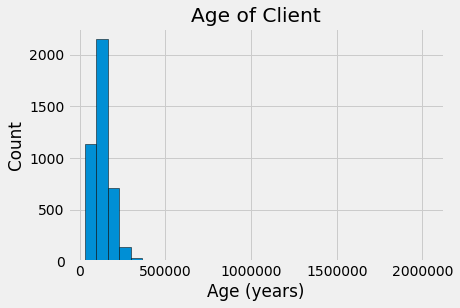

In [108]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_application_train[(df_application_train["DAYS_BIRTH"]/365 * -1) <= 23].AMT_INCOME_TOTAL, edgecolor = 'k', bins = 30)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

# Vehicle loan

In [245]:
link_vehicle_train = "../../data/raw_datasets/new_data/L&T auto loans/train.csv"

temp = pd.read_csv(link_vehicle_train)

In [247]:
temp["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts().size

20

In [239]:
link_vehicle_dict = "../../data/raw_datasets/new_data/L&T auto loans/data_dictionary.csv"

df_vehicle_dict = pd.read_csv(link_vehicle_dict)

In [274]:
def drop_useless_var(df):
    
    df=df.drop(['UniqueID', 
                'branch_id',
                'supplier_id', 
                'Current_pincode_ID',
                'State_ID', 
                'Employee_code_ID', 
                'MobileNo_Avl_Flag'], axis=1)

    return df

def get_age_at_loan(df):
    
    def age(dur):
        
        '''
        support function
        '''
        
        yr = int(dur.split('-')[2])
        
        if yr >=0 and yr<=19:
            return yr+2000
        else:
             return yr+1900
            
    df = df.copy()
    
    l_dates = ["Date.of.Birth", "DisbursalDate"]
    
    for col in l_dates:
        
        df[col] = df[col].apply(age)
        
    df["age"] = df['DisbursalDate'] - df['Date.of.Birth']
    
    df = df.drop(['DisbursalDate','Date.of.Birth'], axis = 1)
    
    return df 

def filter_young_people(df):
    
    df = df[df["age"] <= 23]
    
    return df

def convert_year_t_month(df):
    
    l_dates = ["AVERAGE.ACCT.AGE", "CREDIT.HISTORY.LENGTH"]
    
    for col in l_dates:
    
        df[col] = (pd.to_numeric(df[col].str.split("yrs").str[0]) * 12) + pd.to_numeric(df[col].str.split().str[1].str.split("mon").str[0])
    
    return df

def get_grades(x):
            
    p = x.split("-")

    if len(p) == 1:  
        return "unknown"
    else:
        return p[0]

    
def combine_primary_secondary_accounts(df):
    
    df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
    df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
    df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
    df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
    df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
    df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
    df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
    df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
    df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
    
    df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)
    
    return df
    
def pre_processing(df):
    
    #df = df.set_index("UniqueID")
    df = drop_useless_var(df)
    
    df = get_age_at_loan(df)
    
    df = filter_young_people(df)
    
    df = convert_year_t_month(df)
    
    df["PERFORM_CNS.SCORE.DESCRIPTION"] = df["PERFORM_CNS.SCORE.DESCRIPTION"].apply(get_grades)
    
    df = combine_primary_secondary_accounts(df)
    
    df['Missing Features'] = (df == 0).astype(int).sum(axis=1)
    
    return df


temp = pre_processing(df_vehicle_train)
        

In [282]:
df_vehicle_dict

Unnamed: 0                        Variable Name  \
0            0                             UniqueID   
1            1                         loan_default   
2            2                     disbursed_amount   
3            3                           asset_cost   
4            4                                  ltv   
5            5                            branch_id   
6            6                          supplier_id   
7            7                      manufacturer_id   
8            8                      Current_pincode   
9            9                        Date.of.Birth   
10          10                      Employment.Type   
11          11                        DisbursalDate   
12          12                             State_ID   
13          13                     Employee_code_ID   
14          14                    MobileNo_Avl_Flag   
15          15                          Aadhar_flag   
16          16                             PAN_flag   
17          17                         VoterID_flag   
18          18                         Driving_flag   
19          19                        Passport_flag   
20          20                    PERFORM_CNS.SCORE   
21          21        PERFORM_CNS.SCORE.DESCRIPTION   
22          22                      PRI.NO.OF.ACCTS   
23          23                     PRI.ACTIVE.ACCTS   
24          24                    PRI.OVERDUE.ACCTS   
25          25                  PRI.CURRENT.BALANCE   
26          26                PRI.SANCTIONED.AMOUNT   
27          27                 PRI.DISBURSED.AMOUNT   
28          28                      SEC.NO.OF.ACCTS   
29          29                     SEC.ACTIVE.ACCTS   
30          30                    SEC.OVERDUE.ACCTS   
31          31                  SEC.CURRENT.BALANCE   
32          32                SEC.SANCTIONED.AMOUNT   
33          33                 SEC.DISBURSED.AMOUNT   
34          34                   PRIMARY.INSTAL.AMT   
35          35                       SEC.INSTAL.AMT   
36          36         NEW.ACCTS.IN.LAST.SIX.MONTHS   
37          37  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS   
38          38                     AVERAGE.ACCT.AGE   
39          39                CREDIT.HISTORY.LENGTH   
40          40                      NO.OF_INQUIRIES   

                                                                           Description  \
0                                                             Identifier for customers   
1                                         Payment default in the first EMI on due date   
2                                                             Amount of Loan disbursed   
3                                                                    Cost of the Asset   
4                                                           Loan to Value of the asset   
5                                                  Branch where the loan was disbursed   
6                                          Vehicle Dealer where the loan was disbursed   
7                                          Vehicle manufacturer(Hero, Honda, TVS etc.)   
8                                                      Current pincode of the customer   
9                                                        Date of birth of the customer   
10                            Employment Type of the customer (Salaried/Self Employed)   
11                                                                Date of disbursement   
12                                                               State of disbursement   
13                            Employee of the organization who logged the disbursement   
14                          if Mobile no. was shared by the customer then flagged as 1   
15                              if aadhar was shared by the customer then flagged as 1   
16                                 if pan was shared by the customer then flagged as 1   
17                              if voter  was shared by the customer then

In [268]:
temp

asset_cost    ltv  manufacturer_id Employment.Type  Aadhar_flag  \
33           60630  72.57               45   Self employed            1   
39           58400  89.55               45        Salaried            1   
56           62413  84.60               45        Salaried            1   
64           63000  82.54               45        Salaried            1   
71           63840  68.92               45        Salaried            1   
...            ...    ...              ...             ...          ...   
233086       70055  88.93               45        Salaried            0   
233105       68791  79.81               45   Self employed            0   
233108       93396  68.00              120   Self employed            0   
233135       60334  66.30               48        Salaried            0   
233141       45233  66.32               48        Salaried            0   

        PAN_flag  VoterID_flag  Driving_flag  Passport_flag  \
33             0             0             0              0   
39             0             0             0              0   
56             0             0             0              0   
64             0             0             0              0   
71             0             0             0              0   
...          ...           ...           ...            ...   
233086         1             1             0              0   
233105         1             1             0              0   
233108         1             1             0              0   
233135         0             1             0              0   
233141         0             1             0              0   

        PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
33                      0                       unknown   
39                      0                       unknown   
56                    762                             B   
64                      0                       unknown   
71                      0                       unknown   
...                   ...                           ...   
233086                  0                       unknown   
233105                  0                       unknown   
233108                  0                       unknown   
233135                  0                       unknown   
233141                825                             A   

        NEW.ACCTS.IN.LAST.SIX.MONTHS  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
33                                 0                                    0   
39                                 0                                    0   
56                                 0                                    0   
64                                 0                                    0   
71                                 0                                    0   
...                              ...                                  ...   
233086                             0                                    0   
233105                             0                                    0   
233108                             0                                    0   
233135                             0                                    0   
233141                             0                                    0   

        AVERAGE.ACCT.AGE  CREDIT.HISTORY.LENGTH  NO.OF_INQUIRIES  \
33                     0                      0                0   
39                     0                      0                0   
56                    14                     17                0   
64                     0                      0                0   
71                     0                      0                0   
...                  ...                    ...              ...   
233086                 0                      0                0   
233105                 0                      0                0   
233108                 0                      0                0   
233135                 0            

## EDA

In [242]:
temp.dtypes.value_counts()

int64      34
object      6
float64     1
dtype: int64

In [243]:
temp.select_dtypes('object').apply(lambda x: x.nunique())

Date.of.Birth                    15433
Employment.Type                      2
DisbursalDate                       84
PERFORM_CNS.SCORE.DESCRIPTION       20
AVERAGE.ACCT.AGE                   192
CREDIT.HISTORY.LENGTH              294
dtype: int64

In [244]:
temp.select_dtypes('object')

Date.of.Birth Employment.Type DisbursalDate  \
0           01-01-84        Salaried      03-08-18   
1           31-07-85   Self employed      26-09-18   
2           24-08-85   Self employed      01-08-18   
3           30-12-93   Self employed      26-10-18   
4           09-12-77   Self employed      26-09-18   
...              ...             ...           ...   
233149      01-08-88        Salaried      26-10-18   
233150      05-12-88   Self employed      23-10-18   
233151      01-06-76        Salaried      24-10-18   
233152      26-03-94        Salaried      29-09-18   
233153      18-02-84        Salaried      27-10-18   

       PERFORM_CNS.SCORE.DESCRIPTION AVERAGE.ACCT.AGE CREDIT.HISTORY.LENGTH  
0        No Bureau History Available        0yrs 0mon             0yrs 0mon  
1                      I-Medium Risk       1yrs 11mon            1yrs 11mon  
2        No Bureau History Available        0yrs 0mon             0yrs 0mon  
3                   L-Very High Risk        0yrs 8mon             1yrs 3mon  
4        No Bureau History Available        0yrs 0mon             0yrs 0mon  
...                              ...              ...                   ...  
233149               D-Very Low Risk        1yrs 9mon             3yrs 3mon  
233150               A-Very Low Risk        0yrs 6mon             0yrs 6mon  
233151   No Bureau History Available        0yrs 0mon             0yrs 0mon  
233152   No Bureau History Available        0yrs 0mon             0yrs 0mon  
233153   No Bureau History Available        0yrs 0mon             0yrs 0mon  

[233154 rows x 6 columns]

## Random Forest

### Encode and train test split 

In [327]:
temp_encoded = encode(temp, "loan_default", method = "label", y_col_method = "categorica")

In [308]:
temp["loan_default"].astype("category")

33        0
39        1
56        0
64        0
71        1
         ..
233086    0
233105    1
233108    0
233135    0
233141    0
Name: loan_default, Length: 32708, dtype: category
Categories (2, int64): [0, 1]

In [281]:
temp_encoded.groupby("loan_default")["Missing Features"].mean()

loan_default
0    15.696825
1    14.521928
Name: Missing Features, dtype: float64

In [287]:
temp_encoded.loc[56, "loan_default"]

0

In [290]:
for i in temp_encoded[["No of Accounts", "loan_default"]].iterrows():
    print(i)

(33, No of Accounts    0
loan_default      0
Name: 33, dtype: int64)
(39, No of Accounts    0
loan_default      1
Name: 39, dtype: int64)
(56, No of Accounts    3
loan_default      0
Name: 56, dtype: int64)
(64, No of Accounts    0
loan_default      0
Name: 64, dtype: int64)
(71, No of Accounts    0
loan_default      1
Name: 71, dtype: int64)
(85, No of Accounts    0
loan_default      0
Name: 85, dtype: int64)
(87, No of Accounts    0
loan_default      0
Name: 87, dtype: int64)
(88, No of Accounts    0
loan_default      0
Name: 88, dtype: int64)
(91, No of Accounts    0
loan_default      0
Name: 91, dtype: int64)
(99, No of Accounts    0
loan_default      0
Name: 99, dtype: int64)
(120, No of Accounts    0
loan_default      0
Name: 120, dtype: int64)
(125, No of Accounts    0
loan_default      0
Name: 125, dtype: int64)
(131, No of Accounts    0
loan_default      0
Name: 131, dtype: int64)
(151, No of Accounts    0
loan_default      0
Name: 151, dtype: int64)
(154, No of Accounts    3


Name: 3768, dtype: int64)
(3771, No of Accounts    0
loan_default      0
Name: 3771, dtype: int64)
(3778, No of Accounts    0
loan_default      1
Name: 3778, dtype: int64)
(3787, No of Accounts    12
loan_default       0
Name: 3787, dtype: int64)
(3808, No of Accounts    0
loan_default      0
Name: 3808, dtype: int64)
(3813, No of Accounts    0
loan_default      0
Name: 3813, dtype: int64)
(3816, No of Accounts    0
loan_default      0
Name: 3816, dtype: int64)
(3817, No of Accounts    0
loan_default      1
Name: 3817, dtype: int64)
(3821, No of Accounts    0
loan_default      0
Name: 3821, dtype: int64)
(3833, No of Accounts    1
loan_default      0
Name: 3833, dtype: int64)
(3837, No of Accounts    0
loan_default      1
Name: 3837, dtype: int64)
(3838, No of Accounts    0
loan_default      0
Name: 3838, dtype: int64)
(3840, No of Accounts    0
loan_default      0
Name: 3840, dtype: int64)
(3843, No of Accounts    0
loan_default      0
Name: 3843, dtype: int64)
(3845, No of Accounts  

Name: 6883, dtype: int64)
(6886, No of Accounts    0
loan_default      0
Name: 6886, dtype: int64)
(6888, No of Accounts    1
loan_default      1
Name: 6888, dtype: int64)
(6893, No of Accounts    0
loan_default      0
Name: 6893, dtype: int64)
(6899, No of Accounts    0
loan_default      0
Name: 6899, dtype: int64)
(6902, No of Accounts    0
loan_default      0
Name: 6902, dtype: int64)
(6904, No of Accounts    0
loan_default      0
Name: 6904, dtype: int64)
(6911, No of Accounts    0
loan_default      0
Name: 6911, dtype: int64)
(6912, No of Accounts    0
loan_default      0
Name: 6912, dtype: int64)
(6917, No of Accounts    0
loan_default      0
Name: 6917, dtype: int64)
(6923, No of Accounts    0
loan_default      0
Name: 6923, dtype: int64)
(6931, No of Accounts    0
loan_default      1
Name: 6931, dtype: int64)
(6933, No of Accounts    0
loan_default      0
Name: 6933, dtype: int64)
(6938, No of Accounts    3
loan_default      1
Name: 6938, dtype: int64)
(6941, No of Accounts    

Name: 10798, dtype: int64)
(10799, No of Accounts    0
loan_default      0
Name: 10799, dtype: int64)
(10801, No of Accounts    2
loan_default      0
Name: 10801, dtype: int64)
(10814, No of Accounts    0
loan_default      0
Name: 10814, dtype: int64)
(10818, No of Accounts    0
loan_default      0
Name: 10818, dtype: int64)
(10821, No of Accounts    1
loan_default      0
Name: 10821, dtype: int64)
(10852, No of Accounts    0
loan_default      0
Name: 10852, dtype: int64)
(10856, No of Accounts    0
loan_default      0
Name: 10856, dtype: int64)
(10861, No of Accounts    0
loan_default      0
Name: 10861, dtype: int64)
(10864, No of Accounts    0
loan_default      0
Name: 10864, dtype: int64)
(10872, No of Accounts    0
loan_default      0
Name: 10872, dtype: int64)
(10876, No of Accounts    0
loan_default      0
Name: 10876, dtype: int64)
(10894, No of Accounts    0
loan_default      0
Name: 10894, dtype: int64)
(10901, No of Accounts    0
loan_default      0
Name: 10901, dtype: int64

Name: 15129, dtype: int64)
(15131, No of Accounts    0
loan_default      0
Name: 15131, dtype: int64)
(15139, No of Accounts    0
loan_default      0
Name: 15139, dtype: int64)
(15142, No of Accounts    3
loan_default      0
Name: 15142, dtype: int64)
(15143, No of Accounts    0
loan_default      0
Name: 15143, dtype: int64)
(15144, No of Accounts    0
loan_default      0
Name: 15144, dtype: int64)
(15177, No of Accounts    3
loan_default      0
Name: 15177, dtype: int64)
(15186, No of Accounts    0
loan_default      1
Name: 15186, dtype: int64)
(15187, No of Accounts    1
loan_default      0
Name: 15187, dtype: int64)
(15189, No of Accounts    0
loan_default      0
Name: 15189, dtype: int64)
(15212, No of Accounts    0
loan_default      1
Name: 15212, dtype: int64)
(15224, No of Accounts    0
loan_default      1
Name: 15224, dtype: int64)
(15239, No of Accounts    1
loan_default      1
Name: 15239, dtype: int64)
(15243, No of Accounts    0
loan_default      1
Name: 15243, dtype: int64

Name: 19327, dtype: int64)
(19331, No of Accounts    0
loan_default      1
Name: 19331, dtype: int64)
(19338, No of Accounts    4
loan_default      1
Name: 19338, dtype: int64)
(19345, No of Accounts    0
loan_default      1
Name: 19345, dtype: int64)
(19348, No of Accounts    0
loan_default      0
Name: 19348, dtype: int64)
(19350, No of Accounts    0
loan_default      0
Name: 19350, dtype: int64)
(19351, No of Accounts    4
loan_default      0
Name: 19351, dtype: int64)
(19352, No of Accounts    1
loan_default      1
Name: 19352, dtype: int64)
(19354, No of Accounts    0
loan_default      1
Name: 19354, dtype: int64)
(19363, No of Accounts    0
loan_default      0
Name: 19363, dtype: int64)
(19367, No of Accounts    2
loan_default      0
Name: 19367, dtype: int64)
(19373, No of Accounts    1
loan_default      0
Name: 19373, dtype: int64)
(19378, No of Accounts    0
loan_default      1
Name: 19378, dtype: int64)
(19388, No of Accounts    0
loan_default      0
Name: 19388, dtype: int64

Name: 23359, dtype: int64)
(23360, No of Accounts    0
loan_default      0
Name: 23360, dtype: int64)
(23364, No of Accounts    0
loan_default      0
Name: 23364, dtype: int64)
(23372, No of Accounts    1
loan_default      0
Name: 23372, dtype: int64)
(23374, No of Accounts    1
loan_default      0
Name: 23374, dtype: int64)
(23376, No of Accounts    0
loan_default      0
Name: 23376, dtype: int64)
(23379, No of Accounts    0
loan_default      0
Name: 23379, dtype: int64)
(23391, No of Accounts    0
loan_default      1
Name: 23391, dtype: int64)
(23395, No of Accounts    0
loan_default      0
Name: 23395, dtype: int64)
(23402, No of Accounts    4
loan_default      0
Name: 23402, dtype: int64)
(23405, No of Accounts    3
loan_default      0
Name: 23405, dtype: int64)
(23410, No of Accounts    0
loan_default      0
Name: 23410, dtype: int64)
(23413, No of Accounts    4
loan_default      0
Name: 23413, dtype: int64)
(23429, No of Accounts    0
loan_default      0
Name: 23429, dtype: int64

Name: 27938, dtype: int64)
(27954, No of Accounts    0
loan_default      1
Name: 27954, dtype: int64)
(27971, No of Accounts    0
loan_default      0
Name: 27971, dtype: int64)
(27977, No of Accounts    0
loan_default      1
Name: 27977, dtype: int64)
(27985, No of Accounts    0
loan_default      1
Name: 27985, dtype: int64)
(28000, No of Accounts    0
loan_default      0
Name: 28000, dtype: int64)
(28008, No of Accounts    0
loan_default      0
Name: 28008, dtype: int64)
(28012, No of Accounts    0
loan_default      0
Name: 28012, dtype: int64)
(28019, No of Accounts    0
loan_default      0
Name: 28019, dtype: int64)
(28021, No of Accounts    0
loan_default      0
Name: 28021, dtype: int64)
(28025, No of Accounts    0
loan_default      0
Name: 28025, dtype: int64)
(28034, No of Accounts    2
loan_default      0
Name: 28034, dtype: int64)
(28040, No of Accounts    0
loan_default      1
Name: 28040, dtype: int64)
(28042, No of Accounts    0
loan_default      0
Name: 28042, dtype: int64

Name: 31787, dtype: int64)
(31792, No of Accounts    1
loan_default      0
Name: 31792, dtype: int64)
(31794, No of Accounts    0
loan_default      0
Name: 31794, dtype: int64)
(31803, No of Accounts    0
loan_default      0
Name: 31803, dtype: int64)
(31806, No of Accounts    0
loan_default      1
Name: 31806, dtype: int64)
(31809, No of Accounts    0
loan_default      0
Name: 31809, dtype: int64)
(31814, No of Accounts    0
loan_default      1
Name: 31814, dtype: int64)
(31819, No of Accounts    0
loan_default      0
Name: 31819, dtype: int64)
(31822, No of Accounts    0
loan_default      0
Name: 31822, dtype: int64)
(31825, No of Accounts    7
loan_default      1
Name: 31825, dtype: int64)
(31833, No of Accounts    0
loan_default      0
Name: 31833, dtype: int64)
(31834, No of Accounts    0
loan_default      0
Name: 31834, dtype: int64)
(31835, No of Accounts    0
loan_default      0
Name: 31835, dtype: int64)
(31836, No of Accounts    0
loan_default      0
Name: 31836, dtype: int64

Name: 35458, dtype: int64)
(35468, No of Accounts    1
loan_default      0
Name: 35468, dtype: int64)
(35470, No of Accounts    0
loan_default      0
Name: 35470, dtype: int64)
(35473, No of Accounts    0
loan_default      1
Name: 35473, dtype: int64)
(35477, No of Accounts    0
loan_default      0
Name: 35477, dtype: int64)
(35486, No of Accounts    1
loan_default      0
Name: 35486, dtype: int64)
(35489, No of Accounts    1
loan_default      0
Name: 35489, dtype: int64)
(35490, No of Accounts    0
loan_default      0
Name: 35490, dtype: int64)
(35504, No of Accounts    2
loan_default      0
Name: 35504, dtype: int64)
(35505, No of Accounts    2
loan_default      0
Name: 35505, dtype: int64)
(35523, No of Accounts    0
loan_default      0
Name: 35523, dtype: int64)
(35524, No of Accounts    2
loan_default      1
Name: 35524, dtype: int64)
(35527, No of Accounts    1
loan_default      1
Name: 35527, dtype: int64)
(35531, No of Accounts    0
loan_default      0
Name: 35531, dtype: int64

Name: 39652, dtype: int64)
(39653, No of Accounts    0
loan_default      1
Name: 39653, dtype: int64)
(39690, No of Accounts    0
loan_default      0
Name: 39690, dtype: int64)
(39713, No of Accounts    0
loan_default      0
Name: 39713, dtype: int64)
(39725, No of Accounts    0
loan_default      0
Name: 39725, dtype: int64)
(39733, No of Accounts    0
loan_default      0
Name: 39733, dtype: int64)
(39737, No of Accounts    0
loan_default      0
Name: 39737, dtype: int64)
(39740, No of Accounts    0
loan_default      1
Name: 39740, dtype: int64)
(39757, No of Accounts    1
loan_default      0
Name: 39757, dtype: int64)
(39768, No of Accounts    0
loan_default      0
Name: 39768, dtype: int64)
(39769, No of Accounts    0
loan_default      0
Name: 39769, dtype: int64)
(39772, No of Accounts    0
loan_default      1
Name: 39772, dtype: int64)
(39780, No of Accounts    1
loan_default      0
Name: 39780, dtype: int64)
(39785, No of Accounts    3
loan_default      0
Name: 39785, dtype: int64

Name: 43967, dtype: int64)
(43971, No of Accounts    0
loan_default      0
Name: 43971, dtype: int64)
(43974, No of Accounts    0
loan_default      0
Name: 43974, dtype: int64)
(43976, No of Accounts    0
loan_default      1
Name: 43976, dtype: int64)
(43978, No of Accounts    0
loan_default      0
Name: 43978, dtype: int64)
(43981, No of Accounts    0
loan_default      0
Name: 43981, dtype: int64)
(43984, No of Accounts    0
loan_default      0
Name: 43984, dtype: int64)
(43991, No of Accounts    0
loan_default      0
Name: 43991, dtype: int64)
(43998, No of Accounts    0
loan_default      0
Name: 43998, dtype: int64)
(44002, No of Accounts    0
loan_default      0
Name: 44002, dtype: int64)
(44004, No of Accounts    1
loan_default      1
Name: 44004, dtype: int64)
(44011, No of Accounts    0
loan_default      1
Name: 44011, dtype: int64)
(44015, No of Accounts    0
loan_default      0
Name: 44015, dtype: int64)
(44016, No of Accounts    0
loan_default      1
Name: 44016, dtype: int64

Name: 47783, dtype: int64)
(47788, No of Accounts    1
loan_default      1
Name: 47788, dtype: int64)
(47789, No of Accounts    0
loan_default      0
Name: 47789, dtype: int64)
(47790, No of Accounts    0
loan_default      0
Name: 47790, dtype: int64)
(47792, No of Accounts    0
loan_default      0
Name: 47792, dtype: int64)
(47804, No of Accounts    0
loan_default      0
Name: 47804, dtype: int64)
(47811, No of Accounts    1
loan_default      1
Name: 47811, dtype: int64)
(47819, No of Accounts    0
loan_default      0
Name: 47819, dtype: int64)
(47823, No of Accounts    2
loan_default      0
Name: 47823, dtype: int64)
(47836, No of Accounts    0
loan_default      0
Name: 47836, dtype: int64)
(47841, No of Accounts    0
loan_default      0
Name: 47841, dtype: int64)
(47858, No of Accounts    0
loan_default      0
Name: 47858, dtype: int64)
(47866, No of Accounts    12
loan_default       0
Name: 47866, dtype: int64)
(47869, No of Accounts    3
loan_default      0
Name: 47869, dtype: int

Name: 51587, dtype: int64)
(51600, No of Accounts    0
loan_default      0
Name: 51600, dtype: int64)
(51603, No of Accounts    0
loan_default      1
Name: 51603, dtype: int64)
(51605, No of Accounts    1
loan_default      0
Name: 51605, dtype: int64)
(51606, No of Accounts    0
loan_default      0
Name: 51606, dtype: int64)
(51612, No of Accounts    0
loan_default      0
Name: 51612, dtype: int64)
(51614, No of Accounts    8
loan_default      0
Name: 51614, dtype: int64)
(51615, No of Accounts    2
loan_default      1
Name: 51615, dtype: int64)
(51628, No of Accounts    0
loan_default      1
Name: 51628, dtype: int64)
(51636, No of Accounts    0
loan_default      1
Name: 51636, dtype: int64)
(51637, No of Accounts    2
loan_default      0
Name: 51637, dtype: int64)
(51642, No of Accounts    0
loan_default      0
Name: 51642, dtype: int64)
(51643, No of Accounts    23
loan_default       0
Name: 51643, dtype: int64)
(51655, No of Accounts    0
loan_default      1
Name: 51655, dtype: int

Name: 55215, dtype: int64)
(55222, No of Accounts    0
loan_default      0
Name: 55222, dtype: int64)
(55224, No of Accounts    20
loan_default       0
Name: 55224, dtype: int64)
(55225, No of Accounts    0
loan_default      0
Name: 55225, dtype: int64)
(55231, No of Accounts    0
loan_default      1
Name: 55231, dtype: int64)
(55242, No of Accounts    0
loan_default      0
Name: 55242, dtype: int64)
(55243, No of Accounts    0
loan_default      0
Name: 55243, dtype: int64)
(55256, No of Accounts    0
loan_default      0
Name: 55256, dtype: int64)
(55275, No of Accounts    0
loan_default      0
Name: 55275, dtype: int64)
(55277, No of Accounts    0
loan_default      1
Name: 55277, dtype: int64)
(55283, No of Accounts    0
loan_default      0
Name: 55283, dtype: int64)
(55284, No of Accounts    0
loan_default      0
Name: 55284, dtype: int64)
(55285, No of Accounts    8
loan_default      0
Name: 55285, dtype: int64)
(55290, No of Accounts    0
loan_default      0
Name: 55290, dtype: int

Name: 59033, dtype: int64)
(59037, No of Accounts    2
loan_default      0
Name: 59037, dtype: int64)
(59047, No of Accounts    0
loan_default      0
Name: 59047, dtype: int64)
(59052, No of Accounts    2
loan_default      0
Name: 59052, dtype: int64)
(59054, No of Accounts    0
loan_default      0
Name: 59054, dtype: int64)
(59057, No of Accounts    0
loan_default      0
Name: 59057, dtype: int64)
(59060, No of Accounts    0
loan_default      0
Name: 59060, dtype: int64)
(59073, No of Accounts    1
loan_default      0
Name: 59073, dtype: int64)
(59079, No of Accounts    0
loan_default      0
Name: 59079, dtype: int64)
(59081, No of Accounts    0
loan_default      0
Name: 59081, dtype: int64)
(59085, No of Accounts    0
loan_default      0
Name: 59085, dtype: int64)
(59099, No of Accounts    1
loan_default      0
Name: 59099, dtype: int64)
(59114, No of Accounts    0
loan_default      0
Name: 59114, dtype: int64)
(59115, No of Accounts    1
loan_default      0
Name: 59115, dtype: int64

Name: 62727, dtype: int64)
(62728, No of Accounts    1
loan_default      0
Name: 62728, dtype: int64)
(62733, No of Accounts    0
loan_default      0
Name: 62733, dtype: int64)
(62734, No of Accounts    0
loan_default      1
Name: 62734, dtype: int64)
(62737, No of Accounts    0
loan_default      0
Name: 62737, dtype: int64)
(62743, No of Accounts    0
loan_default      0
Name: 62743, dtype: int64)
(62746, No of Accounts    0
loan_default      0
Name: 62746, dtype: int64)
(62752, No of Accounts    0
loan_default      0
Name: 62752, dtype: int64)
(62753, No of Accounts    1
loan_default      0
Name: 62753, dtype: int64)
(62757, No of Accounts    0
loan_default      1
Name: 62757, dtype: int64)
(62760, No of Accounts    0
loan_default      0
Name: 62760, dtype: int64)
(62766, No of Accounts    6
loan_default      1
Name: 62766, dtype: int64)
(62770, No of Accounts    0
loan_default      0
Name: 62770, dtype: int64)
(62771, No of Accounts    0
loan_default      0
Name: 62771, dtype: int64

Name: 66829, dtype: int64)
(66841, No of Accounts    1
loan_default      0
Name: 66841, dtype: int64)
(66843, No of Accounts    1
loan_default      0
Name: 66843, dtype: int64)
(66845, No of Accounts    0
loan_default      0
Name: 66845, dtype: int64)
(66847, No of Accounts    0
loan_default      0
Name: 66847, dtype: int64)
(66848, No of Accounts    0
loan_default      1
Name: 66848, dtype: int64)
(66853, No of Accounts    0
loan_default      0
Name: 66853, dtype: int64)
(66858, No of Accounts    0
loan_default      0
Name: 66858, dtype: int64)
(66864, No of Accounts    1
loan_default      1
Name: 66864, dtype: int64)
(66871, No of Accounts    2
loan_default      0
Name: 66871, dtype: int64)
(66873, No of Accounts    1
loan_default      1
Name: 66873, dtype: int64)
(66880, No of Accounts    0
loan_default      0
Name: 66880, dtype: int64)
(66881, No of Accounts    0
loan_default      0
Name: 66881, dtype: int64)
(66884, No of Accounts    0
loan_default      0
Name: 66884, dtype: int64

Name: 71072, dtype: int64)
(71074, No of Accounts    0
loan_default      0
Name: 71074, dtype: int64)
(71075, No of Accounts    1
loan_default      0
Name: 71075, dtype: int64)
(71096, No of Accounts    0
loan_default      1
Name: 71096, dtype: int64)
(71098, No of Accounts    5
loan_default      1
Name: 71098, dtype: int64)
(71110, No of Accounts    0
loan_default      1
Name: 71110, dtype: int64)
(71111, No of Accounts    4
loan_default      1
Name: 71111, dtype: int64)
(71114, No of Accounts    0
loan_default      0
Name: 71114, dtype: int64)
(71121, No of Accounts    0
loan_default      1
Name: 71121, dtype: int64)
(71125, No of Accounts    0
loan_default      0
Name: 71125, dtype: int64)
(71131, No of Accounts    4
loan_default      1
Name: 71131, dtype: int64)
(71144, No of Accounts    0
loan_default      0
Name: 71144, dtype: int64)
(71184, No of Accounts    0
loan_default      1
Name: 71184, dtype: int64)
(71186, No of Accounts    0
loan_default      0
Name: 71186, dtype: int64

Name: 74795, dtype: int64)
(74796, No of Accounts    0
loan_default      0
Name: 74796, dtype: int64)
(74798, No of Accounts    0
loan_default      0
Name: 74798, dtype: int64)
(74814, No of Accounts    1
loan_default      0
Name: 74814, dtype: int64)
(74825, No of Accounts    0
loan_default      0
Name: 74825, dtype: int64)
(74827, No of Accounts    1
loan_default      0
Name: 74827, dtype: int64)
(74838, No of Accounts    0
loan_default      0
Name: 74838, dtype: int64)
(74840, No of Accounts    0
loan_default      0
Name: 74840, dtype: int64)
(74854, No of Accounts    0
loan_default      0
Name: 74854, dtype: int64)
(74857, No of Accounts    0
loan_default      1
Name: 74857, dtype: int64)
(74867, No of Accounts    0
loan_default      0
Name: 74867, dtype: int64)
(74880, No of Accounts    0
loan_default      0
Name: 74880, dtype: int64)
(74882, No of Accounts    0
loan_default      0
Name: 74882, dtype: int64)
(74884, No of Accounts    1
loan_default      0
Name: 74884, dtype: int64

Name: 79181, dtype: int64)
(79183, No of Accounts    4
loan_default      1
Name: 79183, dtype: int64)
(79187, No of Accounts    4
loan_default      0
Name: 79187, dtype: int64)
(79188, No of Accounts    1
loan_default      0
Name: 79188, dtype: int64)
(79200, No of Accounts    0
loan_default      0
Name: 79200, dtype: int64)
(79207, No of Accounts    18
loan_default       1
Name: 79207, dtype: int64)
(79216, No of Accounts    9
loan_default      0
Name: 79216, dtype: int64)
(79222, No of Accounts    0
loan_default      0
Name: 79222, dtype: int64)
(79225, No of Accounts    3
loan_default      0
Name: 79225, dtype: int64)
(79230, No of Accounts    0
loan_default      1
Name: 79230, dtype: int64)
(79249, No of Accounts    3
loan_default      0
Name: 79249, dtype: int64)
(79256, No of Accounts    0
loan_default      0
Name: 79256, dtype: int64)
(79258, No of Accounts    1
loan_default      0
Name: 79258, dtype: int64)
(79282, No of Accounts    0
loan_default      0
Name: 79282, dtype: int

Name: 82408, dtype: int64)
(82409, No of Accounts    0
loan_default      0
Name: 82409, dtype: int64)
(82410, No of Accounts    0
loan_default      0
Name: 82410, dtype: int64)
(82412, No of Accounts    0
loan_default      0
Name: 82412, dtype: int64)
(82415, No of Accounts    2
loan_default      1
Name: 82415, dtype: int64)
(82420, No of Accounts    0
loan_default      0
Name: 82420, dtype: int64)
(82425, No of Accounts    0
loan_default      1
Name: 82425, dtype: int64)
(82433, No of Accounts    0
loan_default      1
Name: 82433, dtype: int64)
(82434, No of Accounts    1
loan_default      0
Name: 82434, dtype: int64)
(82447, No of Accounts    0
loan_default      1
Name: 82447, dtype: int64)
(82462, No of Accounts    0
loan_default      0
Name: 82462, dtype: int64)
(82464, No of Accounts    1
loan_default      0
Name: 82464, dtype: int64)
(82469, No of Accounts    0
loan_default      0
Name: 82469, dtype: int64)
(82483, No of Accounts    0
loan_default      0
Name: 82483, dtype: int64

Name: 86465, dtype: int64)
(86469, No of Accounts    0
loan_default      0
Name: 86469, dtype: int64)
(86472, No of Accounts    0
loan_default      1
Name: 86472, dtype: int64)
(86475, No of Accounts    0
loan_default      1
Name: 86475, dtype: int64)
(86481, No of Accounts    0
loan_default      1
Name: 86481, dtype: int64)
(86519, No of Accounts    1
loan_default      0
Name: 86519, dtype: int64)
(86523, No of Accounts    1
loan_default      1
Name: 86523, dtype: int64)
(86526, No of Accounts    0
loan_default      0
Name: 86526, dtype: int64)
(86550, No of Accounts    2
loan_default      0
Name: 86550, dtype: int64)
(86566, No of Accounts    0
loan_default      0
Name: 86566, dtype: int64)
(86574, No of Accounts    0
loan_default      1
Name: 86574, dtype: int64)
(86577, No of Accounts    1
loan_default      0
Name: 86577, dtype: int64)
(86594, No of Accounts    1
loan_default      0
Name: 86594, dtype: int64)
(86595, No of Accounts    0
loan_default      0
Name: 86595, dtype: int64

Name: 90573, dtype: int64)
(90580, No of Accounts    0
loan_default      0
Name: 90580, dtype: int64)
(90584, No of Accounts    0
loan_default      0
Name: 90584, dtype: int64)
(90588, No of Accounts    0
loan_default      1
Name: 90588, dtype: int64)
(90598, No of Accounts    0
loan_default      0
Name: 90598, dtype: int64)
(90608, No of Accounts    0
loan_default      1
Name: 90608, dtype: int64)
(90616, No of Accounts    0
loan_default      0
Name: 90616, dtype: int64)
(90617, No of Accounts    1
loan_default      0
Name: 90617, dtype: int64)
(90623, No of Accounts    1
loan_default      1
Name: 90623, dtype: int64)
(90626, No of Accounts    0
loan_default      0
Name: 90626, dtype: int64)
(90629, No of Accounts    0
loan_default      1
Name: 90629, dtype: int64)
(90635, No of Accounts    0
loan_default      0
Name: 90635, dtype: int64)
(90639, No of Accounts    0
loan_default      1
Name: 90639, dtype: int64)
(90655, No of Accounts    0
loan_default      0
Name: 90655, dtype: int64

Name: 94847, dtype: int64)
(94868, No of Accounts    0
loan_default      0
Name: 94868, dtype: int64)
(94877, No of Accounts    0
loan_default      0
Name: 94877, dtype: int64)
(94881, No of Accounts    0
loan_default      0
Name: 94881, dtype: int64)
(94886, No of Accounts    0
loan_default      0
Name: 94886, dtype: int64)
(94887, No of Accounts    0
loan_default      0
Name: 94887, dtype: int64)
(94896, No of Accounts    0
loan_default      1
Name: 94896, dtype: int64)
(94898, No of Accounts    0
loan_default      0
Name: 94898, dtype: int64)
(94936, No of Accounts    8
loan_default      0
Name: 94936, dtype: int64)
(94941, No of Accounts    1
loan_default      1
Name: 94941, dtype: int64)
(94949, No of Accounts    1
loan_default      1
Name: 94949, dtype: int64)
(94994, No of Accounts    0
loan_default      0
Name: 94994, dtype: int64)
(95011, No of Accounts    6
loan_default      0
Name: 95011, dtype: int64)
(95012, No of Accounts    2
loan_default      0
Name: 95012, dtype: int64

Name: 98874, dtype: int64)
(98886, No of Accounts    0
loan_default      0
Name: 98886, dtype: int64)
(98902, No of Accounts    0
loan_default      0
Name: 98902, dtype: int64)
(98933, No of Accounts    0
loan_default      0
Name: 98933, dtype: int64)
(98937, No of Accounts    0
loan_default      0
Name: 98937, dtype: int64)
(98942, No of Accounts    0
loan_default      0
Name: 98942, dtype: int64)
(98949, No of Accounts    0
loan_default      0
Name: 98949, dtype: int64)
(98957, No of Accounts    0
loan_default      0
Name: 98957, dtype: int64)
(98968, No of Accounts    0
loan_default      1
Name: 98968, dtype: int64)
(98977, No of Accounts    0
loan_default      0
Name: 98977, dtype: int64)
(98983, No of Accounts    0
loan_default      0
Name: 98983, dtype: int64)
(98984, No of Accounts    0
loan_default      0
Name: 98984, dtype: int64)
(98985, No of Accounts    0
loan_default      0
Name: 98985, dtype: int64)
(98986, No of Accounts    3
loan_default      0
Name: 98986, dtype: int64

Name: 102644, dtype: int64)
(102645, No of Accounts    0
loan_default      0
Name: 102645, dtype: int64)
(102648, No of Accounts    1
loan_default      1
Name: 102648, dtype: int64)
(102651, No of Accounts    0
loan_default      0
Name: 102651, dtype: int64)
(102656, No of Accounts    0
loan_default      0
Name: 102656, dtype: int64)
(102663, No of Accounts    0
loan_default      0
Name: 102663, dtype: int64)
(102669, No of Accounts    0
loan_default      1
Name: 102669, dtype: int64)
(102671, No of Accounts    0
loan_default      0
Name: 102671, dtype: int64)
(102674, No of Accounts    1
loan_default      0
Name: 102674, dtype: int64)
(102676, No of Accounts    0
loan_default      0
Name: 102676, dtype: int64)
(102677, No of Accounts    2
loan_default      1
Name: 102677, dtype: int64)
(102678, No of Accounts    0
loan_default      0
Name: 102678, dtype: int64)
(102681, No of Accounts    5
loan_default      1
Name: 102681, dtype: int64)
(102682, No of Accounts    0
loan_default      0

Name: 106357, dtype: int64)
(106364, No of Accounts    0
loan_default      0
Name: 106364, dtype: int64)
(106367, No of Accounts    1
loan_default      0
Name: 106367, dtype: int64)
(106370, No of Accounts    0
loan_default      0
Name: 106370, dtype: int64)
(106372, No of Accounts    0
loan_default      0
Name: 106372, dtype: int64)
(106373, No of Accounts    1
loan_default      1
Name: 106373, dtype: int64)
(106375, No of Accounts    0
loan_default      0
Name: 106375, dtype: int64)
(106376, No of Accounts    0
loan_default      0
Name: 106376, dtype: int64)
(106382, No of Accounts    0
loan_default      0
Name: 106382, dtype: int64)
(106394, No of Accounts    0
loan_default      0
Name: 106394, dtype: int64)
(106398, No of Accounts    3
loan_default      0
Name: 106398, dtype: int64)
(106403, No of Accounts    0
loan_default      1
Name: 106403, dtype: int64)
(106407, No of Accounts    0
loan_default      1
Name: 106407, dtype: int64)
(106410, No of Accounts    0
loan_default      1

Name: 110109, dtype: int64)
(110112, No of Accounts    0
loan_default      1
Name: 110112, dtype: int64)
(110117, No of Accounts    1
loan_default      0
Name: 110117, dtype: int64)
(110121, No of Accounts    1
loan_default      0
Name: 110121, dtype: int64)
(110136, No of Accounts    0
loan_default      0
Name: 110136, dtype: int64)
(110148, No of Accounts    0
loan_default      0
Name: 110148, dtype: int64)
(110154, No of Accounts    0
loan_default      0
Name: 110154, dtype: int64)
(110155, No of Accounts    0
loan_default      1
Name: 110155, dtype: int64)
(110171, No of Accounts    0
loan_default      0
Name: 110171, dtype: int64)
(110172, No of Accounts    0
loan_default      1
Name: 110172, dtype: int64)
(110173, No of Accounts    0
loan_default      0
Name: 110173, dtype: int64)
(110174, No of Accounts    0
loan_default      0
Name: 110174, dtype: int64)
(110175, No of Accounts    0
loan_default      0
Name: 110175, dtype: int64)
(110189, No of Accounts    0
loan_default      0

Name: 113939, dtype: int64)
(113943, No of Accounts    0
loan_default      1
Name: 113943, dtype: int64)
(113948, No of Accounts    0
loan_default      0
Name: 113948, dtype: int64)
(113968, No of Accounts    1
loan_default      1
Name: 113968, dtype: int64)
(113979, No of Accounts    0
loan_default      0
Name: 113979, dtype: int64)
(113991, No of Accounts    0
loan_default      0
Name: 113991, dtype: int64)
(114007, No of Accounts    0
loan_default      0
Name: 114007, dtype: int64)
(114011, No of Accounts    0
loan_default      0
Name: 114011, dtype: int64)
(114013, No of Accounts    0
loan_default      0
Name: 114013, dtype: int64)
(114017, No of Accounts    0
loan_default      1
Name: 114017, dtype: int64)
(114023, No of Accounts    0
loan_default      0
Name: 114023, dtype: int64)
(114027, No of Accounts    0
loan_default      0
Name: 114027, dtype: int64)
(114033, No of Accounts    0
loan_default      0
Name: 114033, dtype: int64)
(114037, No of Accounts    0
loan_default      0

Name: 117586, dtype: int64)
(117603, No of Accounts    1
loan_default      0
Name: 117603, dtype: int64)
(117605, No of Accounts    0
loan_default      0
Name: 117605, dtype: int64)
(117614, No of Accounts    0
loan_default      1
Name: 117614, dtype: int64)
(117615, No of Accounts    0
loan_default      1
Name: 117615, dtype: int64)
(117620, No of Accounts    0
loan_default      1
Name: 117620, dtype: int64)
(117644, No of Accounts    0
loan_default      0
Name: 117644, dtype: int64)
(117647, No of Accounts    0
loan_default      1
Name: 117647, dtype: int64)
(117666, No of Accounts    0
loan_default      0
Name: 117666, dtype: int64)
(117671, No of Accounts    2
loan_default      0
Name: 117671, dtype: int64)
(117674, No of Accounts    0
loan_default      0
Name: 117674, dtype: int64)
(117679, No of Accounts    0
loan_default      0
Name: 117679, dtype: int64)
(117680, No of Accounts    0
loan_default      0
Name: 117680, dtype: int64)
(117690, No of Accounts    0
loan_default      0

Name: 120769, dtype: int64)
(120777, No of Accounts    0
loan_default      0
Name: 120777, dtype: int64)
(120803, No of Accounts    0
loan_default      0
Name: 120803, dtype: int64)
(120824, No of Accounts    0
loan_default      0
Name: 120824, dtype: int64)
(120829, No of Accounts    0
loan_default      1
Name: 120829, dtype: int64)
(120873, No of Accounts    0
loan_default      0
Name: 120873, dtype: int64)
(120881, No of Accounts    0
loan_default      0
Name: 120881, dtype: int64)
(120884, No of Accounts    0
loan_default      0
Name: 120884, dtype: int64)
(120894, No of Accounts    0
loan_default      1
Name: 120894, dtype: int64)
(120904, No of Accounts    2
loan_default      0
Name: 120904, dtype: int64)
(120929, No of Accounts    0
loan_default      0
Name: 120929, dtype: int64)
(120938, No of Accounts    0
loan_default      0
Name: 120938, dtype: int64)
(120942, No of Accounts    4
loan_default      0
Name: 120942, dtype: int64)
(120944, No of Accounts    0
loan_default      1

Name: 124486, dtype: int64)
(124494, No of Accounts    0
loan_default      1
Name: 124494, dtype: int64)
(124495, No of Accounts    0
loan_default      0
Name: 124495, dtype: int64)
(124515, No of Accounts    0
loan_default      1
Name: 124515, dtype: int64)
(124529, No of Accounts    0
loan_default      0
Name: 124529, dtype: int64)
(124539, No of Accounts    0
loan_default      0
Name: 124539, dtype: int64)
(124544, No of Accounts    1
loan_default      1
Name: 124544, dtype: int64)
(124570, No of Accounts    0
loan_default      0
Name: 124570, dtype: int64)
(124571, No of Accounts    0
loan_default      0
Name: 124571, dtype: int64)
(124574, No of Accounts    0
loan_default      0
Name: 124574, dtype: int64)
(124578, No of Accounts    0
loan_default      0
Name: 124578, dtype: int64)
(124579, No of Accounts    0
loan_default      0
Name: 124579, dtype: int64)
(124580, No of Accounts    0
loan_default      0
Name: 124580, dtype: int64)
(124590, No of Accounts    1
loan_default      0

Name: 128111, dtype: int64)
(128119, No of Accounts    0
loan_default      0
Name: 128119, dtype: int64)
(128130, No of Accounts    1
loan_default      1
Name: 128130, dtype: int64)
(128135, No of Accounts    0
loan_default      0
Name: 128135, dtype: int64)
(128159, No of Accounts    0
loan_default      1
Name: 128159, dtype: int64)
(128164, No of Accounts    0
loan_default      0
Name: 128164, dtype: int64)
(128174, No of Accounts    0
loan_default      0
Name: 128174, dtype: int64)
(128177, No of Accounts    0
loan_default      0
Name: 128177, dtype: int64)
(128183, No of Accounts    0
loan_default      1
Name: 128183, dtype: int64)
(128186, No of Accounts    0
loan_default      1
Name: 128186, dtype: int64)
(128191, No of Accounts    1
loan_default      1
Name: 128191, dtype: int64)
(128193, No of Accounts    1
loan_default      1
Name: 128193, dtype: int64)
(128199, No of Accounts    1
loan_default      1
Name: 128199, dtype: int64)
(128211, No of Accounts    0
loan_default      1

Name: 131631, dtype: int64)
(131632, No of Accounts    0
loan_default      0
Name: 131632, dtype: int64)
(131633, No of Accounts    0
loan_default      1
Name: 131633, dtype: int64)
(131650, No of Accounts    2
loan_default      0
Name: 131650, dtype: int64)
(131666, No of Accounts    0
loan_default      1
Name: 131666, dtype: int64)
(131673, No of Accounts    0
loan_default      1
Name: 131673, dtype: int64)
(131678, No of Accounts    0
loan_default      0
Name: 131678, dtype: int64)
(131694, No of Accounts    2
loan_default      0
Name: 131694, dtype: int64)
(131698, No of Accounts    1
loan_default      0
Name: 131698, dtype: int64)
(131703, No of Accounts    3
loan_default      0
Name: 131703, dtype: int64)
(131710, No of Accounts    0
loan_default      1
Name: 131710, dtype: int64)
(131721, No of Accounts    2
loan_default      0
Name: 131721, dtype: int64)
(131727, No of Accounts    0
loan_default      0
Name: 131727, dtype: int64)
(131733, No of Accounts    0
loan_default      0

Name: 135495, dtype: int64)
(135497, No of Accounts    3
loan_default      0
Name: 135497, dtype: int64)
(135499, No of Accounts    0
loan_default      1
Name: 135499, dtype: int64)
(135500, No of Accounts    0
loan_default      0
Name: 135500, dtype: int64)
(135502, No of Accounts    0
loan_default      0
Name: 135502, dtype: int64)
(135505, No of Accounts    0
loan_default      1
Name: 135505, dtype: int64)
(135506, No of Accounts    0
loan_default      0
Name: 135506, dtype: int64)
(135507, No of Accounts    0
loan_default      1
Name: 135507, dtype: int64)
(135508, No of Accounts    0
loan_default      0
Name: 135508, dtype: int64)
(135509, No of Accounts    0
loan_default      0
Name: 135509, dtype: int64)
(135513, No of Accounts    0
loan_default      0
Name: 135513, dtype: int64)
(135514, No of Accounts    0
loan_default      0
Name: 135514, dtype: int64)
(135520, No of Accounts    0
loan_default      0
Name: 135520, dtype: int64)
(135527, No of Accounts    0
loan_default      1

Name: 138732, dtype: int64)
(138735, No of Accounts    0
loan_default      1
Name: 138735, dtype: int64)
(138739, No of Accounts    7
loan_default      0
Name: 138739, dtype: int64)
(138742, No of Accounts    6
loan_default      0
Name: 138742, dtype: int64)
(138750, No of Accounts    0
loan_default      1
Name: 138750, dtype: int64)
(138751, No of Accounts    0
loan_default      1
Name: 138751, dtype: int64)
(138754, No of Accounts    12
loan_default       0
Name: 138754, dtype: int64)
(138757, No of Accounts    0
loan_default      0
Name: 138757, dtype: int64)
(138764, No of Accounts    2
loan_default      0
Name: 138764, dtype: int64)
(138771, No of Accounts    1
loan_default      0
Name: 138771, dtype: int64)
(138784, No of Accounts    1
loan_default      0
Name: 138784, dtype: int64)
(138804, No of Accounts    0
loan_default      0
Name: 138804, dtype: int64)
(138808, No of Accounts    0
loan_default      0
Name: 138808, dtype: int64)
(138809, No of Accounts    0
loan_default     

(142244, No of Accounts    0
loan_default      0
Name: 142244, dtype: int64)
(142248, No of Accounts    0
loan_default      0
Name: 142248, dtype: int64)
(142262, No of Accounts    0
loan_default      1
Name: 142262, dtype: int64)
(142269, No of Accounts    0
loan_default      1
Name: 142269, dtype: int64)
(142271, No of Accounts    2
loan_default      0
Name: 142271, dtype: int64)
(142277, No of Accounts    0
loan_default      0
Name: 142277, dtype: int64)
(142284, No of Accounts    0
loan_default      0
Name: 142284, dtype: int64)
(142296, No of Accounts    0
loan_default      0
Name: 142296, dtype: int64)
(142301, No of Accounts    0
loan_default      1
Name: 142301, dtype: int64)
(142302, No of Accounts    0
loan_default      0
Name: 142302, dtype: int64)
(142317, No of Accounts    0
loan_default      0
Name: 142317, dtype: int64)
(142324, No of Accounts    0
loan_default      0
Name: 142324, dtype: int64)
(142334, No of Accounts    0
loan_default      1
Name: 142334, dtype: int64)

Name: 145733, dtype: int64)
(145734, No of Accounts    0
loan_default      0
Name: 145734, dtype: int64)
(145737, No of Accounts    2
loan_default      1
Name: 145737, dtype: int64)
(145740, No of Accounts    1
loan_default      1
Name: 145740, dtype: int64)
(145745, No of Accounts    0
loan_default      0
Name: 145745, dtype: int64)
(145760, No of Accounts    0
loan_default      0
Name: 145760, dtype: int64)
(145762, No of Accounts    0
loan_default      0
Name: 145762, dtype: int64)
(145766, No of Accounts    0
loan_default      0
Name: 145766, dtype: int64)
(145800, No of Accounts    1
loan_default      0
Name: 145800, dtype: int64)
(145806, No of Accounts    0
loan_default      0
Name: 145806, dtype: int64)
(145810, No of Accounts    0
loan_default      0
Name: 145810, dtype: int64)
(145811, No of Accounts    0
loan_default      0
Name: 145811, dtype: int64)
(145813, No of Accounts    0
loan_default      0
Name: 145813, dtype: int64)
(145824, No of Accounts    0
loan_default      0

Name: 149563, dtype: int64)
(149568, No of Accounts    0
loan_default      0
Name: 149568, dtype: int64)
(149593, No of Accounts    0
loan_default      0
Name: 149593, dtype: int64)
(149594, No of Accounts    1
loan_default      0
Name: 149594, dtype: int64)
(149602, No of Accounts    0
loan_default      0
Name: 149602, dtype: int64)
(149605, No of Accounts    1
loan_default      0
Name: 149605, dtype: int64)
(149612, No of Accounts    0
loan_default      0
Name: 149612, dtype: int64)
(149613, No of Accounts    5
loan_default      0
Name: 149613, dtype: int64)
(149624, No of Accounts    0
loan_default      0
Name: 149624, dtype: int64)
(149631, No of Accounts    1
loan_default      0
Name: 149631, dtype: int64)
(149638, No of Accounts    2
loan_default      0
Name: 149638, dtype: int64)
(149641, No of Accounts    3
loan_default      1
Name: 149641, dtype: int64)
(149642, No of Accounts    0
loan_default      1
Name: 149642, dtype: int64)
(149644, No of Accounts    0
loan_default      1

Name: 153325, dtype: int64)
(153329, No of Accounts    5
loan_default      0
Name: 153329, dtype: int64)
(153333, No of Accounts    0
loan_default      0
Name: 153333, dtype: int64)
(153340, No of Accounts    0
loan_default      0
Name: 153340, dtype: int64)
(153345, No of Accounts    0
loan_default      1
Name: 153345, dtype: int64)
(153359, No of Accounts    10
loan_default       1
Name: 153359, dtype: int64)
(153360, No of Accounts    0
loan_default      1
Name: 153360, dtype: int64)
(153361, No of Accounts    0
loan_default      0
Name: 153361, dtype: int64)
(153367, No of Accounts    0
loan_default      1
Name: 153367, dtype: int64)
(153368, No of Accounts    0
loan_default      0
Name: 153368, dtype: int64)
(153371, No of Accounts    0
loan_default      1
Name: 153371, dtype: int64)
(153400, No of Accounts    0
loan_default      1
Name: 153400, dtype: int64)
(153403, No of Accounts    0
loan_default      0
Name: 153403, dtype: int64)
(153407, No of Accounts    9
loan_default     

Name: 157278, dtype: int64)
(157292, No of Accounts    0
loan_default      0
Name: 157292, dtype: int64)
(157293, No of Accounts    0
loan_default      0
Name: 157293, dtype: int64)
(157294, No of Accounts    0
loan_default      1
Name: 157294, dtype: int64)
(157305, No of Accounts    0
loan_default      0
Name: 157305, dtype: int64)
(157313, No of Accounts    0
loan_default      1
Name: 157313, dtype: int64)
(157331, No of Accounts    1
loan_default      0
Name: 157331, dtype: int64)
(157336, No of Accounts    1
loan_default      0
Name: 157336, dtype: int64)
(157346, No of Accounts    0
loan_default      0
Name: 157346, dtype: int64)
(157350, No of Accounts    0
loan_default      0
Name: 157350, dtype: int64)
(157375, No of Accounts    2
loan_default      0
Name: 157375, dtype: int64)
(157379, No of Accounts    3
loan_default      1
Name: 157379, dtype: int64)
(157386, No of Accounts    1
loan_default      0
Name: 157386, dtype: int64)
(157441, No of Accounts    0
loan_default      0

Name: 160610, dtype: int64)
(160611, No of Accounts    0
loan_default      0
Name: 160611, dtype: int64)
(160615, No of Accounts    0
loan_default      1
Name: 160615, dtype: int64)
(160624, No of Accounts    0
loan_default      0
Name: 160624, dtype: int64)
(160630, No of Accounts    0
loan_default      0
Name: 160630, dtype: int64)
(160632, No of Accounts    0
loan_default      0
Name: 160632, dtype: int64)
(160633, No of Accounts    0
loan_default      1
Name: 160633, dtype: int64)
(160635, No of Accounts    0
loan_default      0
Name: 160635, dtype: int64)
(160647, No of Accounts    0
loan_default      1
Name: 160647, dtype: int64)
(160648, No of Accounts    0
loan_default      0
Name: 160648, dtype: int64)
(160657, No of Accounts    0
loan_default      1
Name: 160657, dtype: int64)
(160661, No of Accounts    0
loan_default      0
Name: 160661, dtype: int64)
(160667, No of Accounts    0
loan_default      0
Name: 160667, dtype: int64)
(160669, No of Accounts    0
loan_default      0

Name: 164077, dtype: int64)
(164092, No of Accounts    2
loan_default      0
Name: 164092, dtype: int64)
(164094, No of Accounts    0
loan_default      0
Name: 164094, dtype: int64)
(164095, No of Accounts    1
loan_default      0
Name: 164095, dtype: int64)
(164099, No of Accounts    0
loan_default      0
Name: 164099, dtype: int64)
(164107, No of Accounts    0
loan_default      1
Name: 164107, dtype: int64)
(164108, No of Accounts    0
loan_default      0
Name: 164108, dtype: int64)
(164120, No of Accounts    0
loan_default      0
Name: 164120, dtype: int64)
(164123, No of Accounts    2
loan_default      0
Name: 164123, dtype: int64)
(164130, No of Accounts    9
loan_default      1
Name: 164130, dtype: int64)
(164145, No of Accounts    0
loan_default      0
Name: 164145, dtype: int64)
(164148, No of Accounts    0
loan_default      0
Name: 164148, dtype: int64)
(164149, No of Accounts    0
loan_default      0
Name: 164149, dtype: int64)
(164156, No of Accounts    14
loan_default      

Name: 168716, dtype: int64)
(168722, No of Accounts    1
loan_default      0
Name: 168722, dtype: int64)
(168743, No of Accounts    0
loan_default      0
Name: 168743, dtype: int64)
(168749, No of Accounts    3
loan_default      0
Name: 168749, dtype: int64)
(168754, No of Accounts    0
loan_default      0
Name: 168754, dtype: int64)
(168755, No of Accounts    0
loan_default      0
Name: 168755, dtype: int64)
(168758, No of Accounts    0
loan_default      0
Name: 168758, dtype: int64)
(168760, No of Accounts    0
loan_default      0
Name: 168760, dtype: int64)
(168767, No of Accounts    0
loan_default      0
Name: 168767, dtype: int64)
(168776, No of Accounts    0
loan_default      0
Name: 168776, dtype: int64)
(168790, No of Accounts    0
loan_default      0
Name: 168790, dtype: int64)
(168796, No of Accounts    1
loan_default      0
Name: 168796, dtype: int64)
(168811, No of Accounts    0
loan_default      1
Name: 168811, dtype: int64)
(168816, No of Accounts    0
loan_default      0

Name: 172423, dtype: int64)
(172425, No of Accounts    1
loan_default      0
Name: 172425, dtype: int64)
(172429, No of Accounts    0
loan_default      0
Name: 172429, dtype: int64)
(172441, No of Accounts    2
loan_default      0
Name: 172441, dtype: int64)
(172453, No of Accounts    0
loan_default      1
Name: 172453, dtype: int64)
(172457, No of Accounts    0
loan_default      0
Name: 172457, dtype: int64)
(172466, No of Accounts    0
loan_default      0
Name: 172466, dtype: int64)
(172467, No of Accounts    0
loan_default      1
Name: 172467, dtype: int64)
(172475, No of Accounts    0
loan_default      1
Name: 172475, dtype: int64)
(172482, No of Accounts    0
loan_default      1
Name: 172482, dtype: int64)
(172490, No of Accounts    0
loan_default      0
Name: 172490, dtype: int64)
(172514, No of Accounts    0
loan_default      1
Name: 172514, dtype: int64)
(172524, No of Accounts    0
loan_default      0
Name: 172524, dtype: int64)
(172532, No of Accounts    0
loan_default      1

Name: 176636, dtype: int64)
(176638, No of Accounts    1
loan_default      0
Name: 176638, dtype: int64)
(176653, No of Accounts    0
loan_default      0
Name: 176653, dtype: int64)
(176655, No of Accounts    1
loan_default      1
Name: 176655, dtype: int64)
(176656, No of Accounts    0
loan_default      1
Name: 176656, dtype: int64)
(176700, No of Accounts    0
loan_default      1
Name: 176700, dtype: int64)
(176705, No of Accounts    0
loan_default      0
Name: 176705, dtype: int64)
(176706, No of Accounts    1
loan_default      0
Name: 176706, dtype: int64)
(176709, No of Accounts    1
loan_default      0
Name: 176709, dtype: int64)
(176715, No of Accounts    0
loan_default      1
Name: 176715, dtype: int64)
(176716, No of Accounts    0
loan_default      0
Name: 176716, dtype: int64)
(176729, No of Accounts    1
loan_default      0
Name: 176729, dtype: int64)
(176751, No of Accounts    0
loan_default      1
Name: 176751, dtype: int64)
(176757, No of Accounts    0
loan_default      0

Name: 181052, dtype: int64)
(181057, No of Accounts    0
loan_default      1
Name: 181057, dtype: int64)
(181073, No of Accounts    0
loan_default      0
Name: 181073, dtype: int64)
(181102, No of Accounts    0
loan_default      0
Name: 181102, dtype: int64)
(181133, No of Accounts    0
loan_default      0
Name: 181133, dtype: int64)
(181135, No of Accounts    0
loan_default      0
Name: 181135, dtype: int64)
(181145, No of Accounts    0
loan_default      0
Name: 181145, dtype: int64)
(181149, No of Accounts    0
loan_default      0
Name: 181149, dtype: int64)
(181171, No of Accounts    0
loan_default      1
Name: 181171, dtype: int64)
(181187, No of Accounts    0
loan_default      1
Name: 181187, dtype: int64)
(181188, No of Accounts    0
loan_default      0
Name: 181188, dtype: int64)
(181197, No of Accounts    0
loan_default      1
Name: 181197, dtype: int64)
(181202, No of Accounts    0
loan_default      1
Name: 181202, dtype: int64)
(181212, No of Accounts    0
loan_default      0

Name: 185165, dtype: int64)
(185174, No of Accounts    0
loan_default      1
Name: 185174, dtype: int64)
(185178, No of Accounts    2
loan_default      1
Name: 185178, dtype: int64)
(185180, No of Accounts    0
loan_default      0
Name: 185180, dtype: int64)
(185183, No of Accounts    0
loan_default      0
Name: 185183, dtype: int64)
(185197, No of Accounts    0
loan_default      0
Name: 185197, dtype: int64)
(185200, No of Accounts    0
loan_default      0
Name: 185200, dtype: int64)
(185202, No of Accounts    0
loan_default      0
Name: 185202, dtype: int64)
(185204, No of Accounts    0
loan_default      0
Name: 185204, dtype: int64)
(185236, No of Accounts    0
loan_default      0
Name: 185236, dtype: int64)
(185238, No of Accounts    2
loan_default      0
Name: 185238, dtype: int64)
(185251, No of Accounts    0
loan_default      0
Name: 185251, dtype: int64)
(185281, No of Accounts    1
loan_default      0
Name: 185281, dtype: int64)
(185298, No of Accounts    0
loan_default      0

Name: 188667, dtype: int64)
(188680, No of Accounts    4
loan_default      0
Name: 188680, dtype: int64)
(188687, No of Accounts    2
loan_default      0
Name: 188687, dtype: int64)
(188690, No of Accounts    2
loan_default      0
Name: 188690, dtype: int64)
(188691, No of Accounts    0
loan_default      0
Name: 188691, dtype: int64)
(188693, No of Accounts    0
loan_default      1
Name: 188693, dtype: int64)
(188702, No of Accounts    1
loan_default      1
Name: 188702, dtype: int64)
(188713, No of Accounts    0
loan_default      0
Name: 188713, dtype: int64)
(188727, No of Accounts    0
loan_default      0
Name: 188727, dtype: int64)
(188737, No of Accounts    0
loan_default      0
Name: 188737, dtype: int64)
(188776, No of Accounts    0
loan_default      0
Name: 188776, dtype: int64)
(188778, No of Accounts    0
loan_default      1
Name: 188778, dtype: int64)
(188792, No of Accounts    0
loan_default      0
Name: 188792, dtype: int64)
(188794, No of Accounts    0
loan_default      0

Name: 192386, dtype: int64)
(192396, No of Accounts    0
loan_default      0
Name: 192396, dtype: int64)
(192404, No of Accounts    1
loan_default      0
Name: 192404, dtype: int64)
(192406, No of Accounts    0
loan_default      0
Name: 192406, dtype: int64)
(192410, No of Accounts    0
loan_default      0
Name: 192410, dtype: int64)
(192423, No of Accounts    0
loan_default      1
Name: 192423, dtype: int64)
(192458, No of Accounts    2
loan_default      0
Name: 192458, dtype: int64)
(192467, No of Accounts    0
loan_default      0
Name: 192467, dtype: int64)
(192471, No of Accounts    2
loan_default      0
Name: 192471, dtype: int64)
(192479, No of Accounts    1
loan_default      0
Name: 192479, dtype: int64)
(192483, No of Accounts    0
loan_default      1
Name: 192483, dtype: int64)
(192506, No of Accounts    9
loan_default      0
Name: 192506, dtype: int64)
(192509, No of Accounts    0
loan_default      0
Name: 192509, dtype: int64)
(192510, No of Accounts    0
loan_default      0

Name: 196077, dtype: int64)
(196085, No of Accounts    1
loan_default      0
Name: 196085, dtype: int64)
(196090, No of Accounts    1
loan_default      0
Name: 196090, dtype: int64)
(196092, No of Accounts    0
loan_default      1
Name: 196092, dtype: int64)
(196093, No of Accounts    0
loan_default      0
Name: 196093, dtype: int64)
(196101, No of Accounts    0
loan_default      0
Name: 196101, dtype: int64)
(196102, No of Accounts    0
loan_default      0
Name: 196102, dtype: int64)
(196104, No of Accounts    0
loan_default      0
Name: 196104, dtype: int64)
(196109, No of Accounts    0
loan_default      0
Name: 196109, dtype: int64)
(196115, No of Accounts    0
loan_default      0
Name: 196115, dtype: int64)
(196119, No of Accounts    0
loan_default      1
Name: 196119, dtype: int64)
(196120, No of Accounts    0
loan_default      0
Name: 196120, dtype: int64)
(196130, No of Accounts    0
loan_default      0
Name: 196130, dtype: int64)
(196139, No of Accounts    0
loan_default      1

Name: 199298, dtype: int64)
(199299, No of Accounts    3
loan_default      0
Name: 199299, dtype: int64)
(199305, No of Accounts    0
loan_default      0
Name: 199305, dtype: int64)
(199309, No of Accounts    0
loan_default      0
Name: 199309, dtype: int64)
(199315, No of Accounts    0
loan_default      1
Name: 199315, dtype: int64)
(199317, No of Accounts    0
loan_default      1
Name: 199317, dtype: int64)
(199324, No of Accounts    0
loan_default      1
Name: 199324, dtype: int64)
(199335, No of Accounts    0
loan_default      0
Name: 199335, dtype: int64)
(199346, No of Accounts    0
loan_default      0
Name: 199346, dtype: int64)
(199355, No of Accounts    3
loan_default      0
Name: 199355, dtype: int64)
(199360, No of Accounts    8
loan_default      0
Name: 199360, dtype: int64)
(199361, No of Accounts    2
loan_default      0
Name: 199361, dtype: int64)
(199388, No of Accounts    0
loan_default      0
Name: 199388, dtype: int64)
(199401, No of Accounts    0
loan_default      0

Name: 202463, dtype: int64)
(202465, No of Accounts    0
loan_default      0
Name: 202465, dtype: int64)
(202505, No of Accounts    2
loan_default      0
Name: 202505, dtype: int64)
(202517, No of Accounts    1
loan_default      0
Name: 202517, dtype: int64)
(202521, No of Accounts    0
loan_default      0
Name: 202521, dtype: int64)
(202529, No of Accounts    0
loan_default      0
Name: 202529, dtype: int64)
(202536, No of Accounts    1
loan_default      1
Name: 202536, dtype: int64)
(202564, No of Accounts    0
loan_default      0
Name: 202564, dtype: int64)
(202567, No of Accounts    0
loan_default      1
Name: 202567, dtype: int64)
(202591, No of Accounts    0
loan_default      1
Name: 202591, dtype: int64)
(202609, No of Accounts    1
loan_default      0
Name: 202609, dtype: int64)
(202644, No of Accounts    0
loan_default      0
Name: 202644, dtype: int64)
(202646, No of Accounts    0
loan_default      0
Name: 202646, dtype: int64)
(202651, No of Accounts    3
loan_default      0

Name: 206977, dtype: int64)
(206982, No of Accounts    0
loan_default      0
Name: 206982, dtype: int64)
(206984, No of Accounts    0
loan_default      0
Name: 206984, dtype: int64)
(206991, No of Accounts    0
loan_default      0
Name: 206991, dtype: int64)
(206992, No of Accounts    3
loan_default      1
Name: 206992, dtype: int64)
(207006, No of Accounts    1
loan_default      0
Name: 207006, dtype: int64)
(207012, No of Accounts    5
loan_default      0
Name: 207012, dtype: int64)
(207016, No of Accounts    0
loan_default      1
Name: 207016, dtype: int64)
(207019, No of Accounts    0
loan_default      0
Name: 207019, dtype: int64)
(207021, No of Accounts    0
loan_default      0
Name: 207021, dtype: int64)
(207047, No of Accounts    2
loan_default      1
Name: 207047, dtype: int64)
(207059, No of Accounts    0
loan_default      0
Name: 207059, dtype: int64)
(207060, No of Accounts    0
loan_default      0
Name: 207060, dtype: int64)
(207065, No of Accounts    0
loan_default      0

Name: 211434, dtype: int64)
(211453, No of Accounts    0
loan_default      0
Name: 211453, dtype: int64)
(211467, No of Accounts    1
loan_default      0
Name: 211467, dtype: int64)
(211474, No of Accounts    0
loan_default      0
Name: 211474, dtype: int64)
(211495, No of Accounts    0
loan_default      0
Name: 211495, dtype: int64)
(211500, No of Accounts    0
loan_default      1
Name: 211500, dtype: int64)
(211514, No of Accounts    0
loan_default      0
Name: 211514, dtype: int64)
(211520, No of Accounts    0
loan_default      0
Name: 211520, dtype: int64)
(211524, No of Accounts    0
loan_default      0
Name: 211524, dtype: int64)
(211527, No of Accounts    1
loan_default      0
Name: 211527, dtype: int64)
(211528, No of Accounts    0
loan_default      0
Name: 211528, dtype: int64)
(211529, No of Accounts    0
loan_default      0
Name: 211529, dtype: int64)
(211537, No of Accounts    1
loan_default      1
Name: 211537, dtype: int64)
(211538, No of Accounts    0
loan_default      0

Name: 215756, dtype: int64)
(215763, No of Accounts    0
loan_default      1
Name: 215763, dtype: int64)
(215783, No of Accounts    0
loan_default      1
Name: 215783, dtype: int64)
(215795, No of Accounts    0
loan_default      0
Name: 215795, dtype: int64)
(215803, No of Accounts    5
loan_default      1
Name: 215803, dtype: int64)
(215813, No of Accounts    0
loan_default      0
Name: 215813, dtype: int64)
(215815, No of Accounts    3
loan_default      0
Name: 215815, dtype: int64)
(215818, No of Accounts    1
loan_default      1
Name: 215818, dtype: int64)
(215819, No of Accounts    1
loan_default      1
Name: 215819, dtype: int64)
(215820, No of Accounts    0
loan_default      1
Name: 215820, dtype: int64)
(215826, No of Accounts    0
loan_default      0
Name: 215826, dtype: int64)
(215834, No of Accounts    1
loan_default      1
Name: 215834, dtype: int64)
(215835, No of Accounts    3
loan_default      1
Name: 215835, dtype: int64)
(215852, No of Accounts    0
loan_default      1

Name: 219662, dtype: int64)
(219677, No of Accounts    0
loan_default      0
Name: 219677, dtype: int64)
(219689, No of Accounts    4
loan_default      0
Name: 219689, dtype: int64)
(219690, No of Accounts    1
loan_default      0
Name: 219690, dtype: int64)
(219693, No of Accounts    0
loan_default      0
Name: 219693, dtype: int64)
(219700, No of Accounts    1
loan_default      0
Name: 219700, dtype: int64)
(219712, No of Accounts    0
loan_default      1
Name: 219712, dtype: int64)
(219721, No of Accounts    0
loan_default      0
Name: 219721, dtype: int64)
(219724, No of Accounts    0
loan_default      0
Name: 219724, dtype: int64)
(219733, No of Accounts    0
loan_default      0
Name: 219733, dtype: int64)
(219739, No of Accounts    0
loan_default      1
Name: 219739, dtype: int64)
(219743, No of Accounts    1
loan_default      0
Name: 219743, dtype: int64)
(219748, No of Accounts    3
loan_default      0
Name: 219748, dtype: int64)
(219750, No of Accounts    83
loan_default      

Name: 223726, dtype: int64)
(223746, No of Accounts    0
loan_default      1
Name: 223746, dtype: int64)
(223749, No of Accounts    0
loan_default      1
Name: 223749, dtype: int64)
(223753, No of Accounts    4
loan_default      0
Name: 223753, dtype: int64)
(223756, No of Accounts    0
loan_default      0
Name: 223756, dtype: int64)
(223761, No of Accounts    1
loan_default      1
Name: 223761, dtype: int64)
(223762, No of Accounts    1
loan_default      1
Name: 223762, dtype: int64)
(223764, No of Accounts    0
loan_default      0
Name: 223764, dtype: int64)
(223766, No of Accounts    0
loan_default      0
Name: 223766, dtype: int64)
(223771, No of Accounts    1
loan_default      1
Name: 223771, dtype: int64)
(223773, No of Accounts    1
loan_default      0
Name: 223773, dtype: int64)
(223774, No of Accounts    0
loan_default      0
Name: 223774, dtype: int64)
(223778, No of Accounts    0
loan_default      0
Name: 223778, dtype: int64)
(223783, No of Accounts    0
loan_default      0

Name: 228012, dtype: int64)
(228019, No of Accounts    0
loan_default      0
Name: 228019, dtype: int64)
(228033, No of Accounts    0
loan_default      0
Name: 228033, dtype: int64)
(228034, No of Accounts    1
loan_default      0
Name: 228034, dtype: int64)
(228038, No of Accounts    0
loan_default      0
Name: 228038, dtype: int64)
(228056, No of Accounts    0
loan_default      0
Name: 228056, dtype: int64)
(228083, No of Accounts    0
loan_default      0
Name: 228083, dtype: int64)
(228088, No of Accounts    0
loan_default      1
Name: 228088, dtype: int64)
(228112, No of Accounts    0
loan_default      0
Name: 228112, dtype: int64)
(228114, No of Accounts    0
loan_default      0
Name: 228114, dtype: int64)
(228117, No of Accounts    0
loan_default      1
Name: 228117, dtype: int64)
(228118, No of Accounts    0
loan_default      1
Name: 228118, dtype: int64)
(228123, No of Accounts    0
loan_default      0
Name: 228123, dtype: int64)
(228124, No of Accounts    0
loan_default      0

Name: 232716, dtype: int64)
(232719, No of Accounts    0
loan_default      0
Name: 232719, dtype: int64)
(232722, No of Accounts    0
loan_default      0
Name: 232722, dtype: int64)
(232724, No of Accounts    0
loan_default      0
Name: 232724, dtype: int64)
(232727, No of Accounts    0
loan_default      1
Name: 232727, dtype: int64)
(232731, No of Accounts    0
loan_default      0
Name: 232731, dtype: int64)
(232736, No of Accounts    0
loan_default      0
Name: 232736, dtype: int64)
(232743, No of Accounts    0
loan_default      0
Name: 232743, dtype: int64)
(232746, No of Accounts    0
loan_default      0
Name: 232746, dtype: int64)
(232754, No of Accounts    0
loan_default      0
Name: 232754, dtype: int64)
(232761, No of Accounts    0
loan_default      0
Name: 232761, dtype: int64)
(232767, No of Accounts    0
loan_default      1
Name: 232767, dtype: int64)
(232768, No of Accounts    0
loan_default      0
Name: 232768, dtype: int64)
(232797, No of Accounts    0
loan_default      0

In [328]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "loan_default", test_size = 0.15)


### Training

In [278]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 20, 
                            min_samples_leaf = 50)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=50, random_state=42)

Confusion matrix, without normalization
[[3261  438]
 [ 101 1107]]


<Figure size 432x288 with 0 Axes>

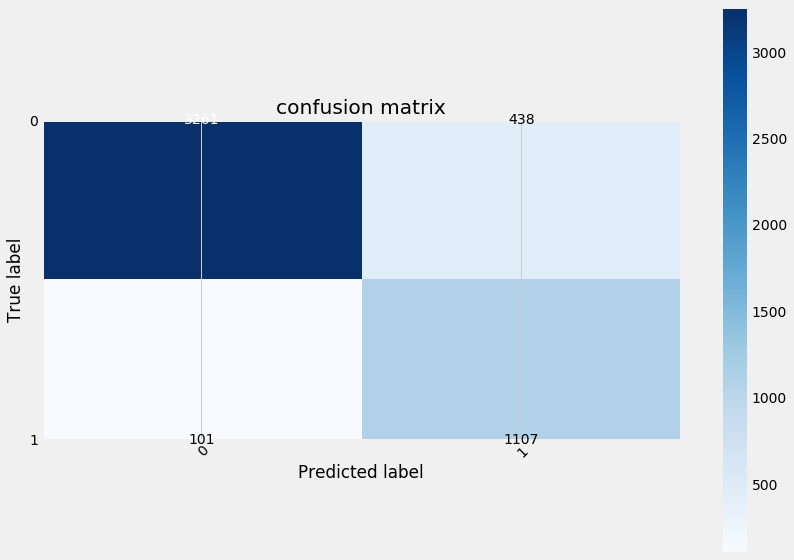

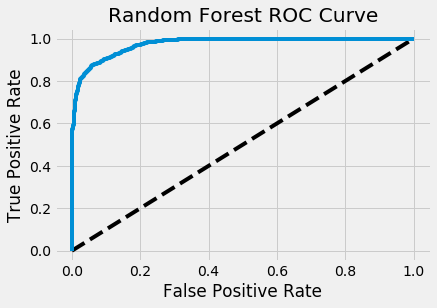

              precision    recall  f1-score   support

       False       0.88      0.97      0.92      3362
        True       0.92      0.72      0.80      1545

    accuracy                           0.89      4907
   macro avg       0.90      0.84      0.86      4907
weighted avg       0.89      0.89      0.89      4907

AUC score is 0.8989901736463588
recall on test set is  0.9163907284768212
accuracy on test set is  0.8901569186875892
recall on training set is  0.94869171173805
accuracy on training set is  0.9026294018200784


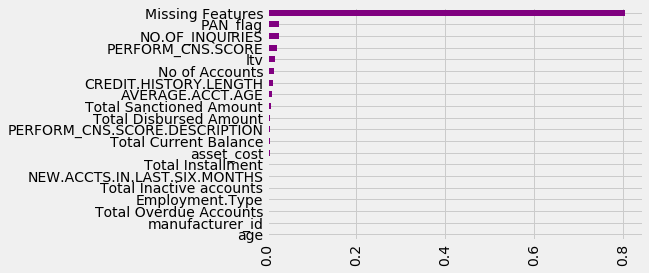

In [279]:
evaluate_model(rf, X_train, y_train, X_test, y_test, [1,0], treshold = 0.5, multi_class = False)

In [201]:
temp_encoded

disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
UniqueID                                                                
451537               42594       60630  72.57         67        22807   
422926               50578       58400  89.55         67        22807   
493777               50475       62413  84.60         78        17014   
539731               49458       63000  82.54         78        17014   
558406               42874       63840  68.92         78        17014   
...                    ...         ...    ...        ...          ...   
550808               60247       70055  88.93         36        15372   
479761               53203       68791  79.81         36        15372   
518936               61456       93396  68.00         36        22881   
624780               39439       60334  66.30         34        20700   
606375               29029       45233  66.32         34        20700   

          manufacturer_id  Current_pincode_ID Employment.Type  State_ID  \
UniqueID                                                                  
451537                 45                1497   Self employed         6   
422926                 45                1577        Salaried         6   
493777                 45                2071        Salaried         4   
539731                 45                2102        Salaried         4   
558406                 45                2102        Salaried         4   
...                   ...                 ...             ...       ...   
550808                 45                6673        Salaried        13   
479761                 45                6616   Self employed        13   
518936                120                6545   Self employed        13   
624780                 48                1051        Salaried         6   
606375                 48                1067        Salaried         6   

          Employee_code_ID  MobileNo_Avl_Flag  Aadhar_flag  PAN_flag  \
UniqueID                                                               
451537                1998                  1            1         0   
422926                1998                  1            1         0   
493777                1646                  1            1         0   
539731                1646                  1            1         0   
558406                1646                  1            1         0   
...                    ...                ...          ...       ...   
550808                2955                  1            0         1   
479761                2955                  1            0         1   
518936                2955                  1            0         1   
624780                3705                  1            0         0   
606375                3705                  1            0         0   

          VoterID_flag  Driving_flag  Passport_flag  PERFORM_CNS.SCORE  \
UniqueID                                                                 
451537               0             0              0                  0   
422926               0             0              0                  0   
493777               0             0              0                762   
539731               0             0              0                  0   
558406               0             0              0                  0   
...                ...           ...            ...                ...   
550808               1             0              0                  0   
479761               1             0              0                  0   
518936               1             0              0                  0   
624780               1             0              0                  0   
606375               1             0              0                825   

         PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  \
UniqueID                                                                    
451537     No Bureau History A

In [202]:
temp.dtypes

disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Employment.Type                         object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.B

In [207]:
l_num_col = temp.columns[(temp.dtypes == "int64") | (temp.dtypes == "float64")].tolist()
   
#add dependent variable
l_num_col.append("loan_default")


In [206]:
l_cat

['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']

In [213]:
df_cat = temp.drop(l_num_col, axis = 1)
    
df_dummies = pd.get_dummies(df_cat)
    
    
df = pd.concat([df_dummies, temp[l_num_col]], axis=1)

# Decision Tree

In [368]:
clf = DecisionTreeClassifier(random_state = SEED, 
                            class_weight = "balanced", 
                            max_depth = 10, 
                            min_samples_leaf = 25)

# Build classification tree
# Build classification tree
tree_est = clf.fit(X_train, y_train)

In [351]:
y_pred = clf.predict(X_test)

Confusion matrix, without normalization
[[3470  229]
 [  62 1146]]


<Figure size 432x288 with 0 Axes>

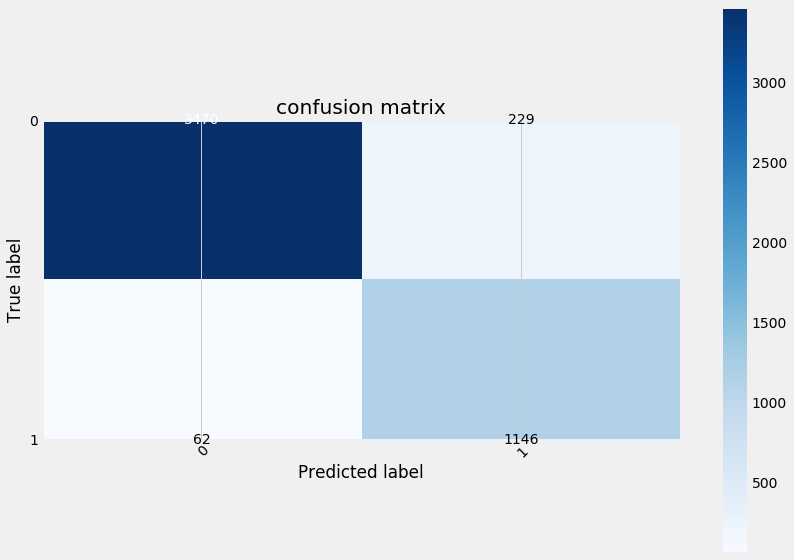

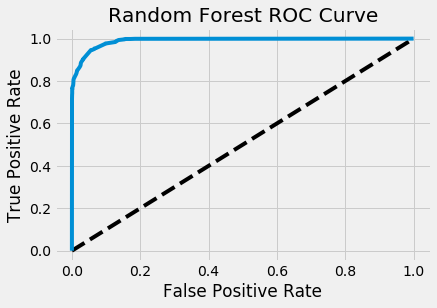

              precision    recall  f1-score   support

       False       0.94      0.98      0.96      3532
        True       0.95      0.83      0.89      1375

    accuracy                           0.94      4907
   macro avg       0.94      0.91      0.92      4907
weighted avg       0.94      0.94      0.94      4907

AUC score is 0.943383436368161
recall on test set is  0.9486754966887417
accuracy on test set is  0.9406969635214999
recall on training set is  0.9560005847098377
accuracy on training set is  0.9457573468580267


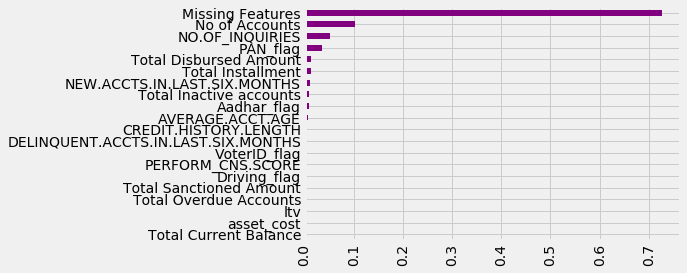

In [369]:
evaluate_model(clf, X_train, y_train, X_test, y_test, [1,0], treshold = 0.5, multi_class = False)


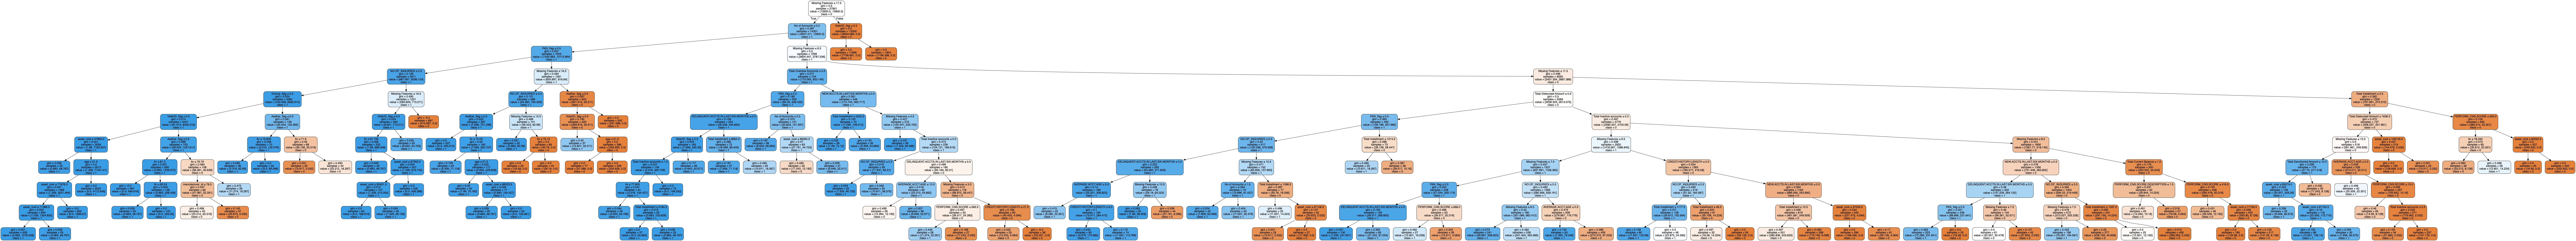

In [371]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
predictors = X_train.columns.tolist()

dot_data = export_graphviz(tree_est, out_file='seat_tree.dot',
                           feature_names=predictors, 
                           class_names= ["0","1"],
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

with open('seat_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

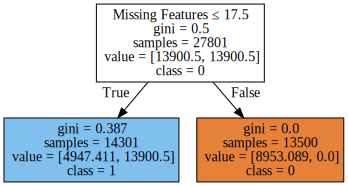

In [355]:
dot_data = tree.export_graphviz(tree_est, out_file=None, 
                    feature_names=predictors,  
                      class_names=["0","1"],  
                   filled=True, 
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 